# Taller 3: Análisis de Redes Sociales para Sortilegios Weasley

## Contexto del Problema

Los gemelos Weasley abrieron su tienda **"Sortilegios Weasley"** en Hogwarts, pero debido a publicidad negativa en **Magictok** están perdiendo clientes. Han logrado obtener una muestra de magos con sus relaciones positivas (+) o negativas (–), y tienen **6.500 galeones** para invertir en publicidad.

**Objetivo:** Lograr que la mayoría de magos conozcan su tienda en **30 días**.

---

## Estructura del Notebook

1. **Visualizaciones de la red**
   - 1a. Gráficas por métricas (Grado, Embajadores, PageRank, VoteRank)
   - 1b. Detección de comunidades

2. **Simulación de difusión (30 días)**
   - Estrategia A: Los gemelos hacen la publicidad
   - Estrategia B: VoteRank + solo magos con relación (+)
   - Estrategia C: Nodos embajadores (descentralizada)

3. **Estrategia alternativa propuesta**

4. **Conclusiones generales**

---
## 0. Importar librerías y cargar datos

In [5]:
import sys
!{sys.executable} -m pip install --user networkx pandas numpy matplotlib seaborn python-louvain
# Librerías básicas
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
import operator
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Para detección de comunidades
try:
    import community as community_louvain
except ImportError:
    print("Instalando python-louvain...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'python-louvain'])
    import community as community_louvain

# Configuración de visualización
plt.rcParams['figure.figsize'] = (14, 10)
sns.set_style("whitegrid")

print("✓ Librerías importadas exitosamente")

  Using cached networkx-3.6-py3-none-any.whl (2.1 MB)
  Using cached python-louvain-0.16.tar.gz (204 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for python-louvain: filename=python_louvain-0.16-py3-none-any.whl size=9473 sha256=bdaf0cf60f14478a21de80a1b2065aa8d5fcc2a4e7735074e952be2a95cbe768
  Stored in directory: c:\users\gabri\appdata\local\pip\cache\wheels\11\c1\e7\f62a211c636275e2da798bf0c307a3ae79aeddaf2524a03ce4
Successfully built python-louvain



[notice] A new release of pip is available: 23.1.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✓ Librerías importadas exitosamente


In [6]:
# Cargar los datos desde la carpeta Taller_3_Claude
import os

# Rutas a los archivos CSV
base_path = './Taller_3_Claude/Taller_3_Claude/'
nodes_file = os.path.join(base_path, 'Nodes_HP1.csv')
edges_file = os.path.join(base_path, 'Edges_HP1.csv')

# Cargar nodos
nodes_df = pd.read_csv(nodes_file, sep=';', encoding='utf-8')
print(f"Nodos cargados: {len(nodes_df)} magos")
print("\nPrimeras filas de nodos:")
display(nodes_df.head())

# Cargar arcos
edges_df = pd.read_csv(edges_file, sep=';', encoding='utf-8')
print(f"\nArcos cargados: {len(edges_df)} relaciones")
print("\nPrimeras filas de arcos:")
display(edges_df.head())

Nodos cargados: 65 magos

Primeras filas de nodos:


,Name,Value
0,"Alastor ""Mad-Eye"" Moody",361
1,Alberforth Dumbledore,36
2,Albus Dumbledore,3025
3,Alice Longbottom,16
4,Aragog,49



Arcos cargados: 510 relaciones

Primeras filas de arcos:


,Source,Target,type
0,"Alastor ""Mad-Eye"" Moody",Harry Potter,+
1,"Alastor ""Mad-Eye"" Moody",Arthur Weasley,+
2,"Alastor ""Mad-Eye"" Moody",Molly Weasley,+
3,"Alastor ""Mad-Eye"" Moody",Hermione Granger,+
4,"Alastor ""Mad-Eye"" Moody",Hermione Granger,+


In [7]:
# Análisis exploratorio básico
print("=" * 60)
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 60)

# Estadísticas de nodos
print("\n📊 ESTADÍSTICAS DE MAGOS (NODOS):")
print(f"  - Total de magos: {len(nodes_df)}")
print(f"  - Costo promedio por mago: {nodes_df['Value'].mean():.2f} galeones")
print(f"  - Costo mínimo: {nodes_df['Value'].min():.0f} galeones")
print(f"  - Costo máximo: {nodes_df['Value'].max():.0f} galeones")
print(f"  - Costo total de todos los magos: {nodes_df['Value'].sum():.0f} galeones")
print(f"  - Fred y George tienen costo: {nodes_df[nodes_df['Name'].str.contains('Fred|George')]['Value'].sum():.0f} galeones")

# Estadísticas de arcos
print("\n📊 ESTADÍSTICAS DE RELACIONES (ARCOS):")
print(f"  - Total de relaciones: {len(edges_df)}")
relaciones_positivas = len(edges_df[edges_df['type'] == '+'])
relaciones_negativas = len(edges_df[edges_df['type'] == '-'])
print(f"  - Relaciones positivas (+): {relaciones_positivas} ({relaciones_positivas/len(edges_df)*100:.1f}%)")
print(f"  - Relaciones negativas (-): {relaciones_negativas} ({relaciones_negativas/len(edges_df)*100:.1f}%)")

ANÁLISIS EXPLORATORIO DE DATOS

📊 ESTADÍSTICAS DE MAGOS (NODOS):
  - Total de magos: 65
  - Costo promedio por mago: 419.37 galeones
  - Costo mínimo: 0 galeones
  - Costo máximo: 3481 galeones
  - Costo total de todos los magos: 27259 galeones
  - Fred y George tienen costo: 0 galeones

📊 ESTADÍSTICAS DE RELACIONES (ARCOS):
  - Total de relaciones: 510
  - Relaciones positivas (+): 354 (69.4%)
  - Relaciones negativas (-): 156 (30.6%)


In [8]:
# Construir el grafo dirigido
G = nx.DiGraph()

# Agregar nodos con sus atributos
for idx, row in nodes_df.iterrows():
    G.add_node(row['Name'], Value=row['Value'])

# Agregar arcos con sus atributos
for idx, row in edges_df.iterrows():
    G.add_edge(row['Source'], row['Target'], tipo=row['type'])

print(f"\n✓ Grafo construido:")
print(f"  - Nodos: {G.number_of_nodes()}")
print(f"  - Arcos: {G.number_of_edges()}")
print(f"  - Densidad: {nx.density(G):.4f}")
print(f"  - ¿Es conexo? {nx.is_weakly_connected(G)}")

# Convertir a no dirigido para algunos cálculos
G_undirected = G.to_undirected()
print(f"\n✓ Grafo no dirigido creado para análisis de comunidades")


✓ Grafo construido:
  - Nodos: 65
  - Arcos: 453
  - Densidad: 0.1089
  - ¿Es conexo? True

✓ Grafo no dirigido creado para análisis de comunidades


---
## 1. VISUALIZACIONES DE LA RED

### 1a. Gráficas por métricas de centralidad

In [9]:
# Calcular métricas de centralidad
print("Calculando métricas de centralidad...")

# 1. Grado (in-degree + out-degree)
degree_centrality = dict(G.degree())
in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())

# 2. PageRank
pagerank = nx.pagerank(G)

# 3. VoteRank
voterank_nodes = nx.voterank(G, number_of_nodes=len(G.nodes()))
voterank_dict = {node: len(voterank_nodes) - rank for rank, node in enumerate(voterank_nodes)}
# Agregar 0 a los nodos que no están en voterank
for node in G.nodes():
    if node not in voterank_dict:
        voterank_dict[node] = 0

# 4. Embajadores (betweenness centrality)
betweenness = nx.betweenness_centrality(G)

print("✓ Métricas calculadas exitosamente")

# Agregar métricas como atributos de los nodos
nx.set_node_attributes(G, degree_centrality, 'degree')
nx.set_node_attributes(G, pagerank, 'pagerank')
nx.set_node_attributes(G, voterank_dict, 'voterank')
nx.set_node_attributes(G, betweenness, 'betweenness')

Calculando métricas de centralidad...
✓ Métricas calculadas exitosamente


In [10]:
# Función para visualizar la red con diferentes métricas
def plot_network_by_metric(G, metric_name, metric_dict, title, use_color=True, use_size=True):
    """
    Visualiza la red coloreando y/o dimensionando nodos según una métrica.
    
    Parámetros:
    - G: Grafo de NetworkX
    - metric_name: Nombre de la métrica (string)
    - metric_dict: Diccionario con valores de la métrica para cada nodo
    - title: Título del gráfico
    - use_color: Si True, colorea nodos según Value
    - use_size: Si True, dimensiona nodos según la métrica
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Posiciones de los nodos usando el layout spring
    pos = nx.spring_layout(G, k=0.5, iterations=50, seed=42)
    
    # Colores según Value (costo)
    if use_color:
        node_values = [G.nodes[node]['Value'] for node in G.nodes()]
        node_colors = node_values
        cmap = plt.cm.YlOrRd
    else:
        node_colors = 'lightblue'
        cmap = None
    
    # Tamaños según la métrica
    if use_size:
        metric_values = np.array([metric_dict.get(node, 0) for node in G.nodes()])
        # Normalizar tamaños entre 50 y 1000
        if metric_values.max() > 0:
            node_sizes = 50 + (metric_values / metric_values.max()) * 950
        else:
            node_sizes = 100
    else:
        node_sizes = 100
    
    # Dibujar la red
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color='gray', arrows=False, ax=ax)
    
    nodes = nx.draw_networkx_nodes(G, pos, 
                                   node_color=node_colors, 
                                   node_size=node_sizes,
                                   cmap=cmap,
                                   alpha=0.8,
                                   ax=ax)
    
    # Agregar barra de color si se usa color
    if use_color and cmap:
        cbar = plt.colorbar(nodes, ax=ax, label='Costo (Galeones)')
    
    # Etiquetar los top 10 nodos según la métrica
    top_nodes = sorted(metric_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    top_node_names = [node for node, _ in top_nodes]
    labels = {node: node if node in top_node_names else '' for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=8, font_weight='bold', ax=ax)
    
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print(f"\n📊 Top 10 nodos por {metric_name}:")
    print("-" * 70)
    for i, (node, value) in enumerate(top_nodes, 1):
        cost = G.nodes[node]['Value']
        print(f"{i:2d}. {node:30s} | {metric_name}: {value:8.4f} | Costo: {cost:6.0f} galeones")
    print("-" * 70)

VISUALIZACIÓN 1: RED SEGÚN GRADO (DEGREE)

El GRADO representa el número total de conexiones de un mago.
Magos con alto grado tienen muchas relaciones y pueden influir directamente a muchos otros.


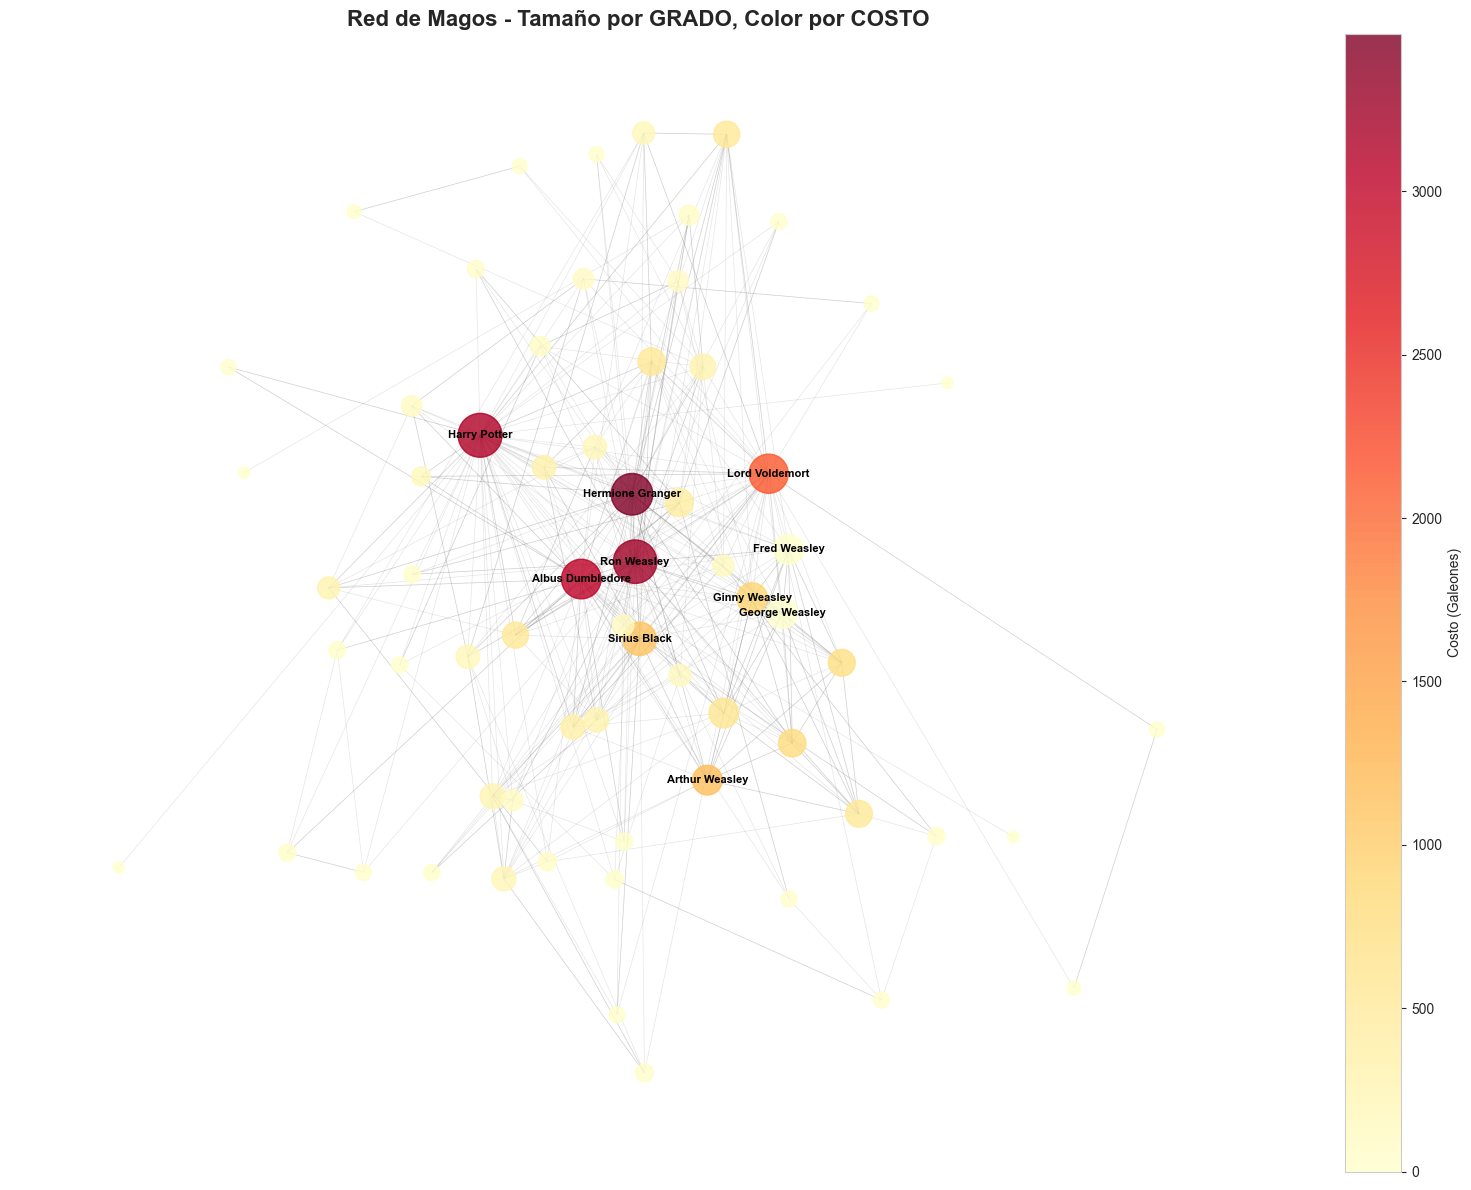


📊 Top 10 nodos por Grado:
----------------------------------------------------------------------
 1. Harry Potter                   | Grado:  56.0000 | Costo:   3136 galeones
 2. Ron Weasley                    | Grado:  55.0000 | Costo:   3249 galeones
 3. Hermione Granger               | Grado:  50.0000 | Costo:   3481 galeones
 4. Albus Dumbledore               | Grado:  45.0000 | Costo:   3025 galeones
 5. Lord Voldemort                 | Grado:  44.0000 | Costo:   2116 galeones
 6. Sirius Black                   | Grado:  31.0000 | Costo:   1089 galeones
 7. George Weasley                 | Grado:  26.0000 | Costo:      0 galeones
 8. Ginny Weasley                  | Grado:  26.0000 | Costo:    900 galeones
 9. Fred Weasley                   | Grado:  25.0000 | Costo:      0 galeones
10. Arthur Weasley                 | Grado:  24.0000 | Costo:   1156 galeones
----------------------------------------------------------------------


In [11]:
# VISUALIZACIÓN 1: Red por GRADO
print("="*70)
print("VISUALIZACIÓN 1: RED SEGÚN GRADO (DEGREE)")
print("="*70)
print("\nEl GRADO representa el número total de conexiones de un mago.")
print("Magos con alto grado tienen muchas relaciones y pueden influir directamente a muchos otros.")

plot_network_by_metric(G, 'Grado', degree_centrality, 
                       'Red de Magos - Tamaño por GRADO, Color por COSTO')

VISUALIZACIÓN 2: RED SEGÚN EMBAJADORES (BETWEENNESS)

Los EMBAJADORES son magos que conectan diferentes grupos.
Tienen alta betweenness: muchos caminos más cortos pasan por ellos.
Son ideales para difundir información entre comunidades distintas.


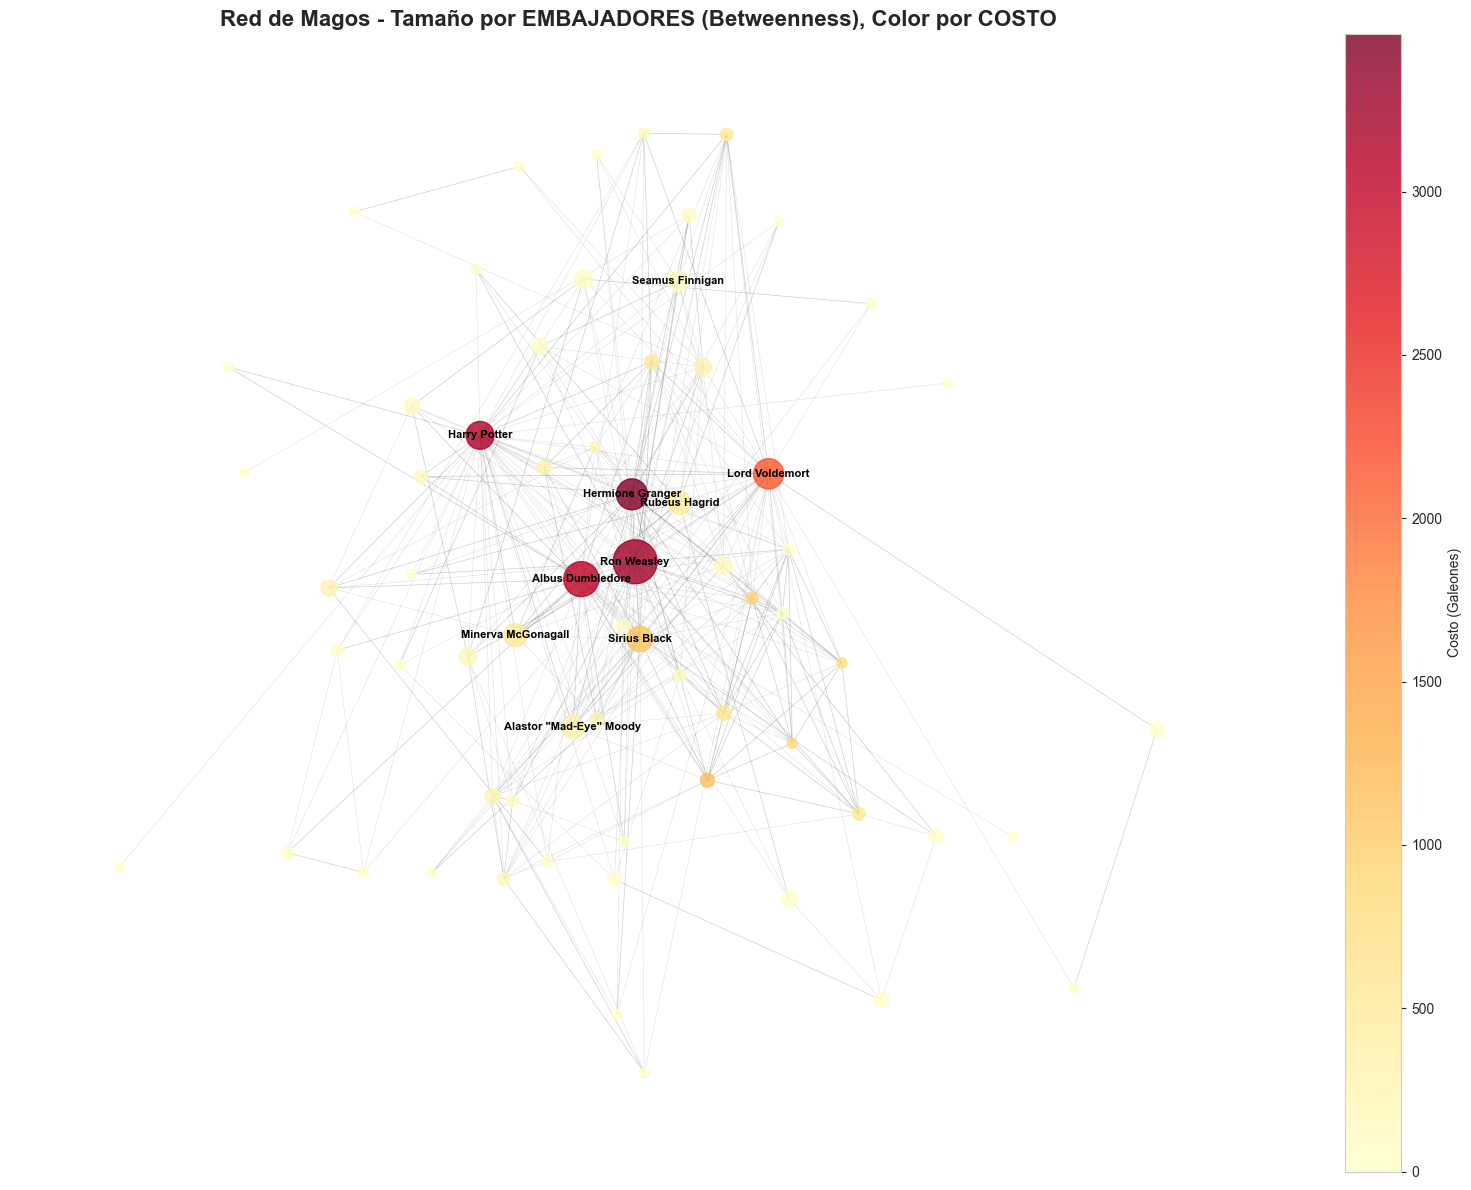


📊 Top 10 nodos por Betweenness:
----------------------------------------------------------------------
 1. Ron Weasley                    | Betweenness:   0.2562 | Costo:   3249 galeones
 2. Albus Dumbledore               | Betweenness:   0.1581 | Costo:   3025 galeones
 3. Hermione Granger               | Betweenness:   0.1211 | Costo:   3481 galeones
 4. Lord Voldemort                 | Betweenness:   0.1151 | Costo:   2116 galeones
 5. Harry Potter                   | Betweenness:   0.0953 | Costo:   3136 galeones
 6. Sirius Black                   | Betweenness:   0.0768 | Costo:   1089 galeones
 7. Rubeus Hagrid                  | Betweenness:   0.0647 | Costo:    441 galeones
 8. Minerva McGonagall             | Betweenness:   0.0621 | Costo:    529 galeones
 9. Alastor "Mad-Eye" Moody        | Betweenness:   0.0553 | Costo:    361 galeones
10. Seamus Finnigan                | Betweenness:   0.0439 | Costo:    100 galeones
--------------------------------------------------------

In [12]:
# VISUALIZACIÓN 2: Red por EMBAJADORES (Betweenness)
print("="*70)
print("VISUALIZACIÓN 2: RED SEGÚN EMBAJADORES (BETWEENNESS)")
print("="*70)
print("\nLos EMBAJADORES son magos que conectan diferentes grupos.")
print("Tienen alta betweenness: muchos caminos más cortos pasan por ellos.")
print("Son ideales para difundir información entre comunidades distintas.")

plot_network_by_metric(G, 'Betweenness', betweenness, 
                       'Red de Magos - Tamaño por EMBAJADORES (Betweenness), Color por COSTO')

VISUALIZACIÓN 3: RED SEGÚN PAGERANK

PAGERANK mide la importancia de un mago considerando la calidad de sus conexiones.
Un mago tiene alto PageRank si está conectado a otros magos importantes.
Es como tener 'influencia de influencers'.


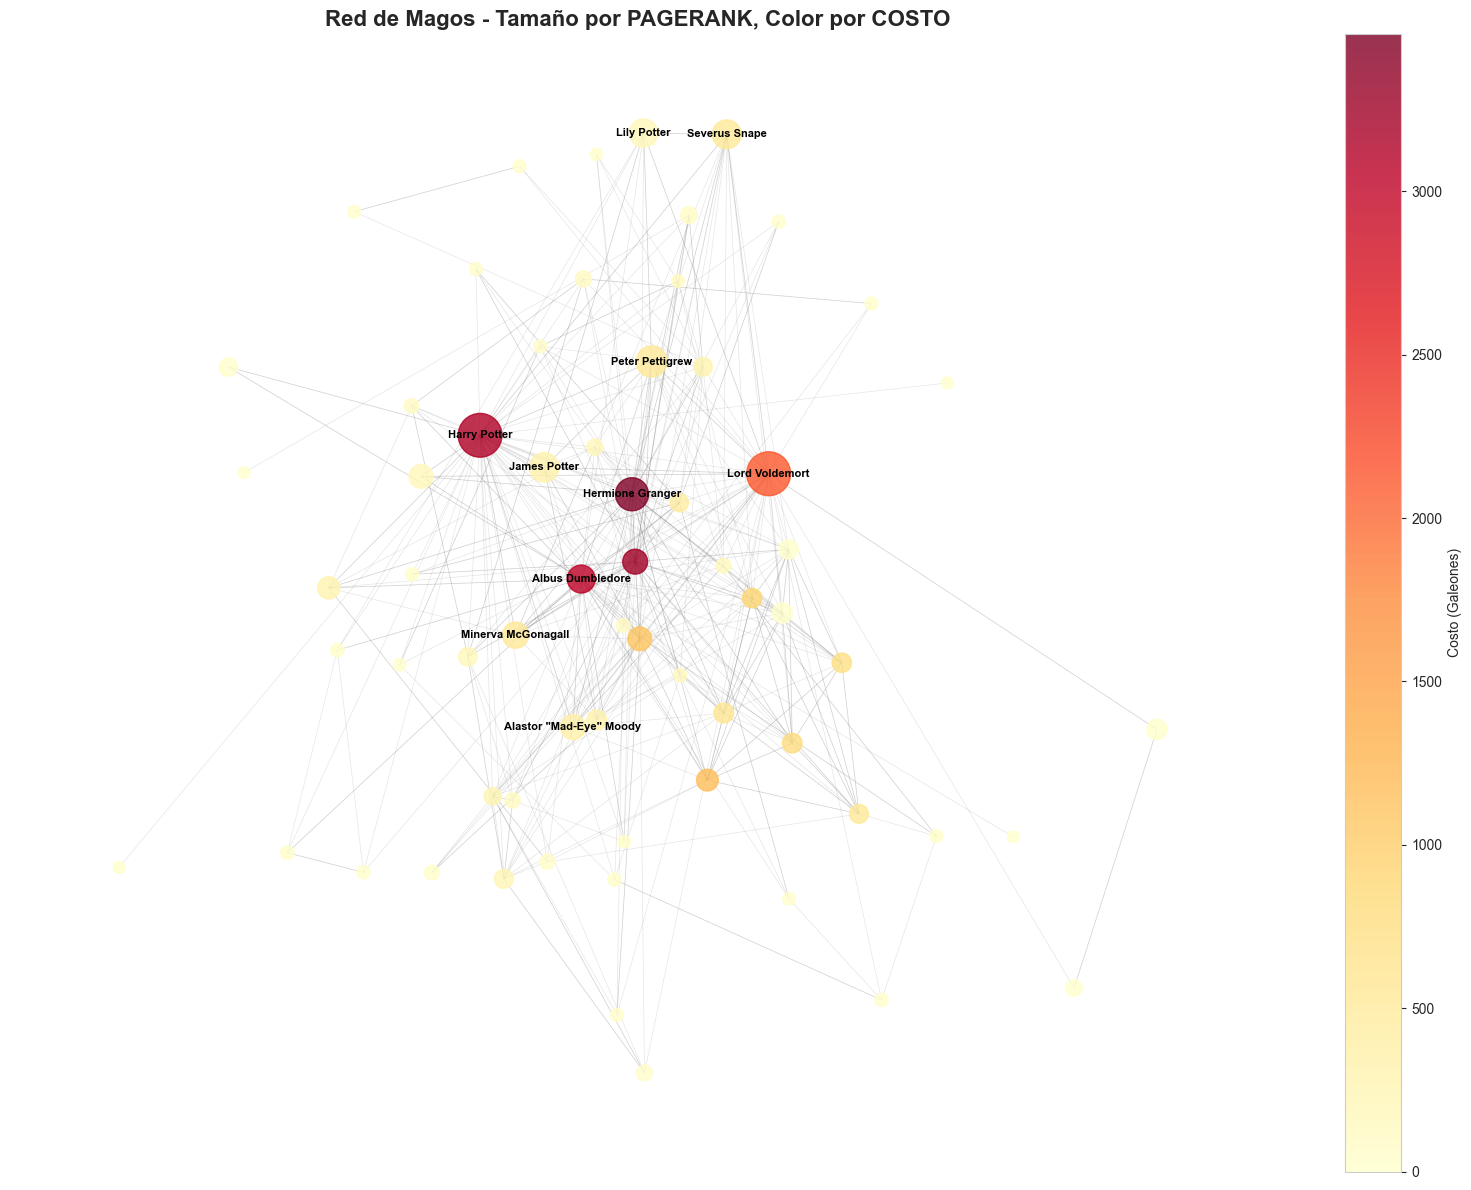


📊 Top 10 nodos por PageRank:
----------------------------------------------------------------------
 1. Lord Voldemort                 | PageRank:   0.0964 | Costo:   2116 galeones
 2. Harry Potter                   | PageRank:   0.0958 | Costo:   3136 galeones
 3. Hermione Granger               | PageRank:   0.0526 | Costo:   3481 galeones
 4. Peter Pettigrew                | PageRank:   0.0453 | Costo:    529 galeones
 5. James Potter                   | PageRank:   0.0404 | Costo:    324 galeones
 6. Severus Snape                  | PageRank:   0.0385 | Costo:    529 galeones
 7. Lily Potter                    | PageRank:   0.0372 | Costo:    196 galeones
 8. Albus Dumbledore               | PageRank:   0.0359 | Costo:   3025 galeones
 9. Minerva McGonagall             | PageRank:   0.0309 | Costo:    529 galeones
10. Alastor "Mad-Eye" Moody        | PageRank:   0.0278 | Costo:    361 galeones
----------------------------------------------------------------------


In [13]:
# VISUALIZACIÓN 3: Red por PAGERANK
print("="*70)
print("VISUALIZACIÓN 3: RED SEGÚN PAGERANK")
print("="*70)
print("\nPAGERANK mide la importancia de un mago considerando la calidad de sus conexiones.")
print("Un mago tiene alto PageRank si está conectado a otros magos importantes.")
print("Es como tener 'influencia de influencers'.")

plot_network_by_metric(G, 'PageRank', pagerank, 
                       'Red de Magos - Tamaño por PAGERANK, Color por COSTO')

VISUALIZACIÓN 4: RED SEGÚN VOTERANK

VOTERANK identifica nodos que pueden alcanzar eficientemente al resto de la red.
Selecciona nodos de forma iterativa considerando que no estén muy cerca entre sí.
Es ideal para maximizar el alcance con pocos nodos semilla.


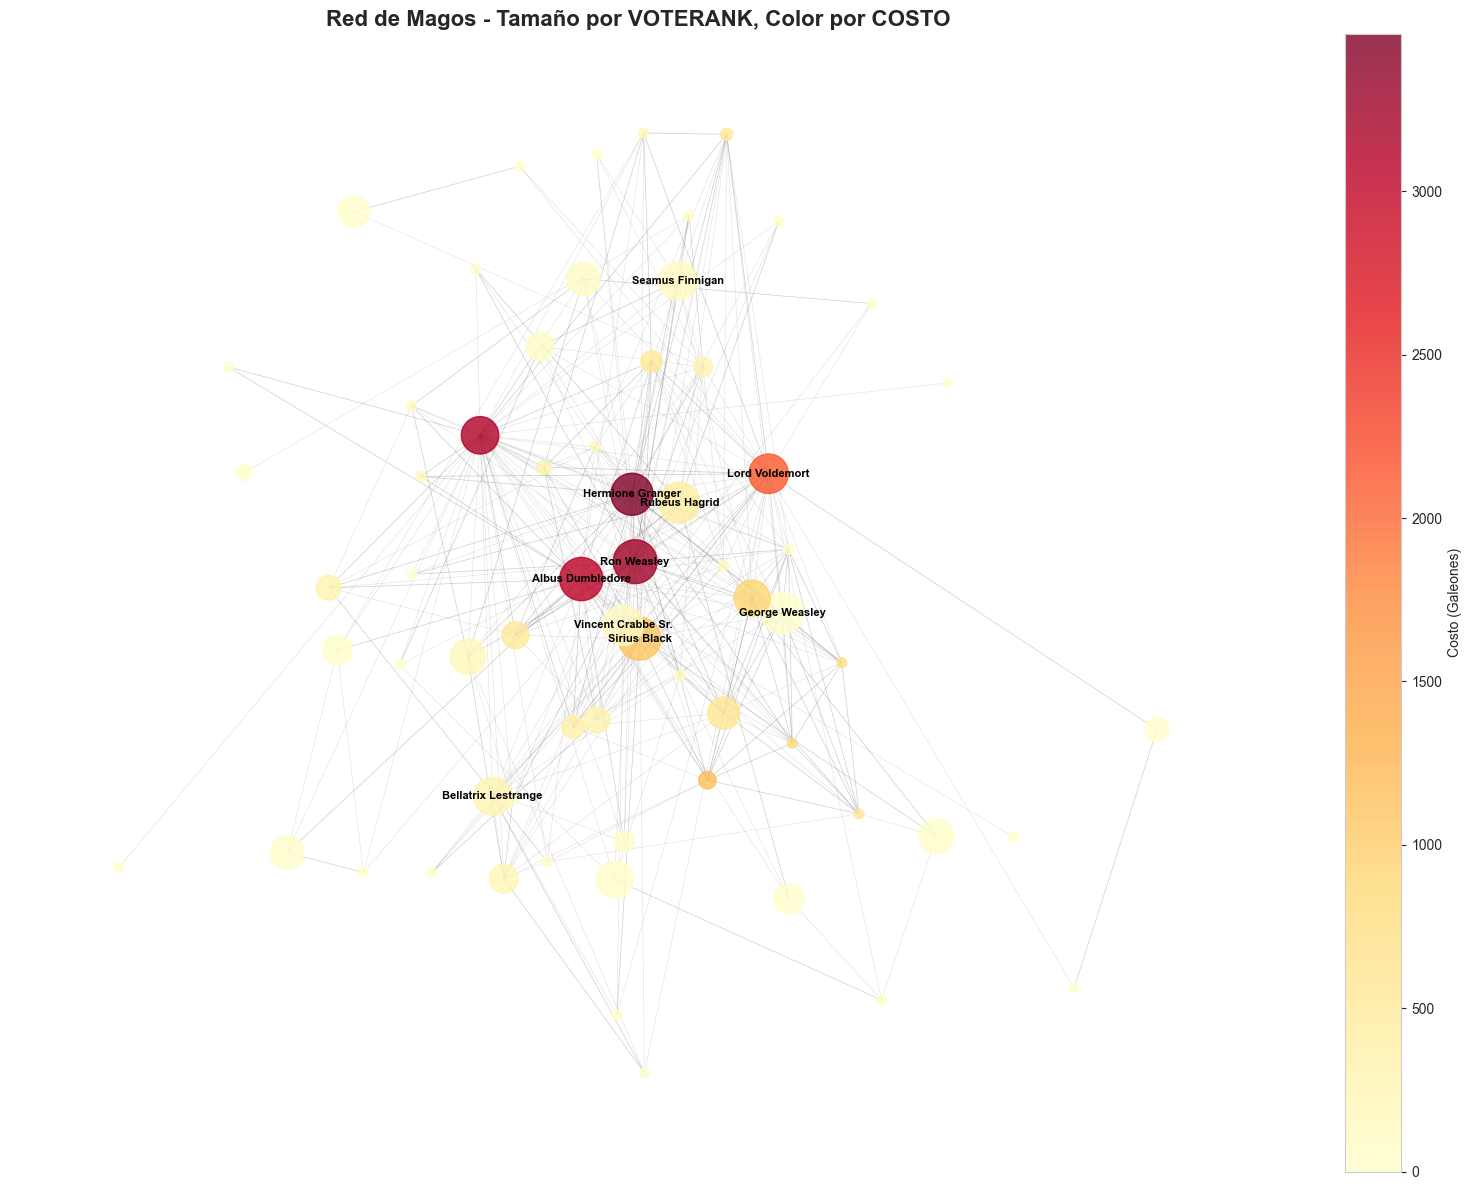


📊 Top 10 nodos por VoteRank:
----------------------------------------------------------------------
 1. Ron Weasley                    | VoteRank:  35.0000 | Costo:   3249 galeones
 2. Albus Dumbledore               | VoteRank:  34.0000 | Costo:   3025 galeones
 3. Sirius Black                   | VoteRank:  33.0000 | Costo:   1089 galeones
 4. Hermione Granger               | VoteRank:  32.0000 | Costo:   3481 galeones
 5. George Weasley                 | VoteRank:  31.0000 | Costo:      0 galeones
 6. Rubeus Hagrid                  | VoteRank:  30.0000 | Costo:    441 galeones
 7. Vincent Crabbe Sr.             | VoteRank:  29.0000 | Costo:    121 galeones
 8. Lord Voldemort                 | VoteRank:  28.0000 | Costo:   2116 galeones
 9. Seamus Finnigan                | VoteRank:  27.0000 | Costo:    100 galeones
10. Bellatrix Lestrange            | VoteRank:  26.0000 | Costo:    256 galeones
----------------------------------------------------------------------


In [14]:
# VISUALIZACIÓN 4: Red por VOTERANK
print("="*70)
print("VISUALIZACIÓN 4: RED SEGÚN VOTERANK")
print("="*70)
print("\nVOTERANK identifica nodos que pueden alcanzar eficientemente al resto de la red.")
print("Selecciona nodos de forma iterativa considerando que no estén muy cerca entre sí.")
print("Es ideal para maximizar el alcance con pocos nodos semilla.")

plot_network_by_metric(G, 'VoteRank', voterank_dict, 
                       'Red de Magos - Tamaño por VOTERANK, Color por COSTO')

### 1b. Detección y visualización de comunidades

In [15]:
# Detectar comunidades usando Louvain
print("="*70)
print("DETECCIÓN DE COMUNIDADES")
print("="*70)
print("\nUsando el algoritmo de Louvain para detectar grupos naturales de magos...\n")

# Aplicar Louvain sobre el grafo no dirigido
partition = community_louvain.best_partition(G_undirected)

# Agregar comunidad como atributo
nx.set_node_attributes(G, partition, 'community')

# Estadísticas de comunidades
num_communities = len(set(partition.values()))
print(f"✓ Se detectaron {num_communities} comunidades\n")

# Analizar cada comunidad
community_stats = []
for com in set(partition.values()):
    nodes_in_com = [node for node, c in partition.items() if c == com]
    
    # Encontrar el nodo con mayor grado en la comunidad
    degrees_in_com = {node: degree_centrality[node] for node in nodes_in_com}
    hub_node = max(degrees_in_com, key=degrees_in_com.get)
    hub_degree = degrees_in_com[hub_node]
    hub_cost = G.nodes[hub_node]['Value']
    
    community_stats.append({
        'Comunidad': com,
        'Tamaño': len(nodes_in_com),
        'Hub': hub_node,
        'Grado_Hub': hub_degree,
        'Costo_Hub': hub_cost
    })

# Crear DataFrame con estadísticas
community_df = pd.DataFrame(community_stats)
community_df = community_df.sort_values('Tamaño', ascending=False)

print("📊 TABLA DE COMUNIDADES:")
print("=" * 90)
display(community_df)

print(f"\n💰 Costo total de contratar todos los hubs: {community_df['Costo_Hub'].sum():.0f} galeones")
print(f"💰 Presupuesto disponible: 6,500 galeones")
print(f"💰 Diferencia: {6500 - community_df['Costo_Hub'].sum():.0f} galeones")

DETECCIÓN DE COMUNIDADES

Usando el algoritmo de Louvain para detectar grupos naturales de magos...

✓ Se detectaron 5 comunidades

📊 TABLA DE COMUNIDADES:


,Comunidad,Tamaño,Hub,Grado_Hub,Costo_Hub
0,0,17,Albus Dumbledore,45,3025
3,3,16,Ron Weasley,55,3249
1,1,13,Harry Potter,56,3136
2,2,10,Bellatrix Lestrange,16,256
4,4,9,George Weasley,26,0



💰 Costo total de contratar todos los hubs: 9666 galeones
💰 Presupuesto disponible: 6,500 galeones
💰 Diferencia: -3166 galeones



Visualizando comunidades...



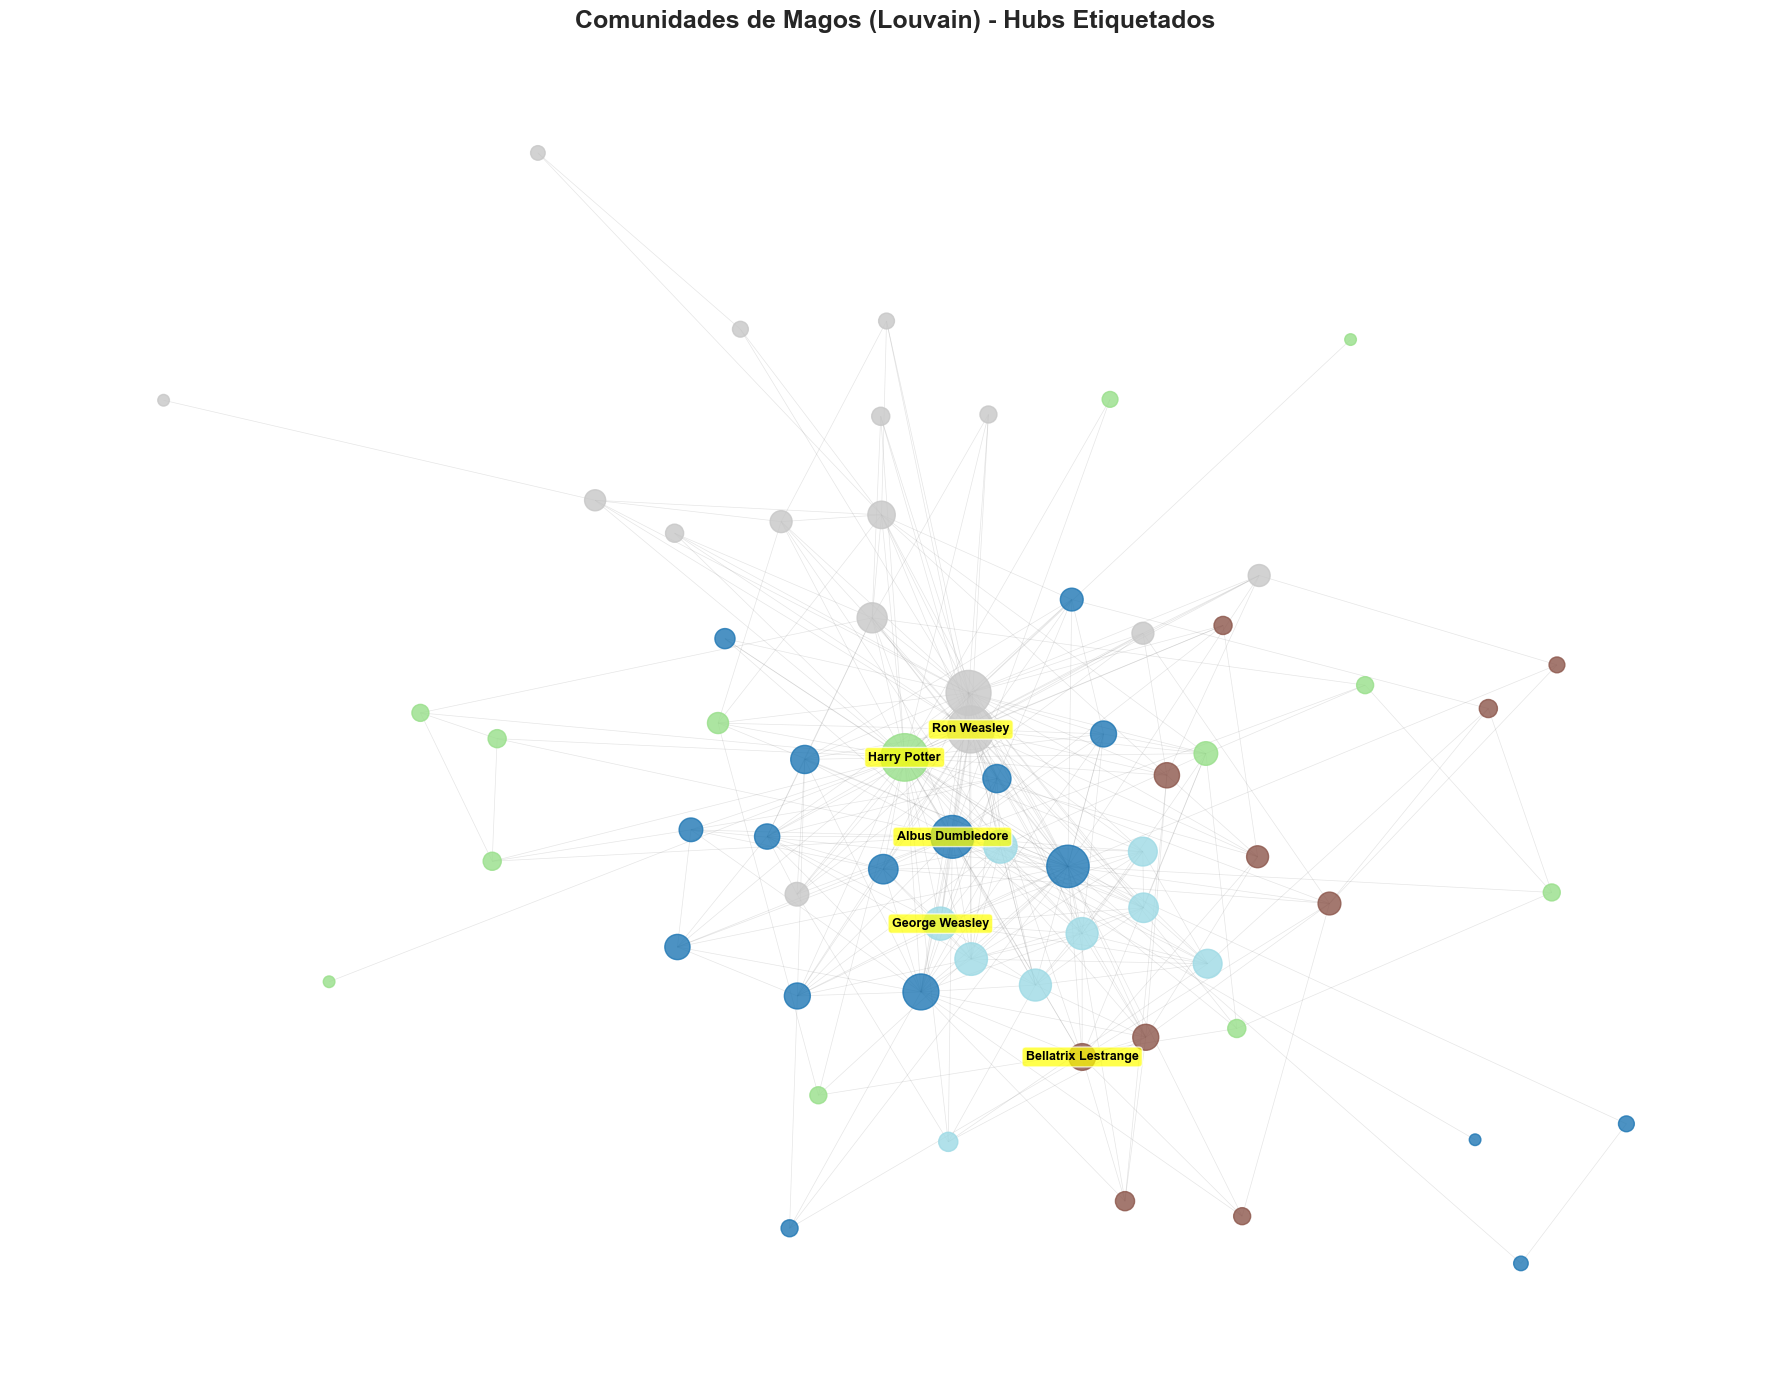

✓ Visualización completada

💡 INTERPRETACIÓN:
   - Cada color representa una comunidad diferente
   - Los nodos más grandes tienen mayor grado
   - Los nodos etiquetados son los HUBS (mayor grado) de cada comunidad


In [16]:
# Visualizar comunidades
print("\nVisualizando comunidades...\n")

fig, ax = plt.subplots(figsize=(18, 14))

# Posiciones
pos = nx.spring_layout(G_undirected, k=0.5, iterations=50, seed=42)

# Colores por comunidad
colors = plt.cm.tab20(np.linspace(0, 1, num_communities))
node_colors = [colors[partition[node]] for node in G_undirected.nodes()]

# Tamaños por grado
node_sizes = [50 + degree_centrality[node] * 20 for node in G_undirected.nodes()]

# Dibujar red
nx.draw_networkx_edges(G_undirected, pos, alpha=0.2, width=0.5, edge_color='gray', ax=ax)
nx.draw_networkx_nodes(G_undirected, pos, 
                       node_color=node_colors, 
                       node_size=node_sizes,
                       alpha=0.8,
                       ax=ax)

# Etiquetar los hubs de cada comunidad
hub_labels = {row['Hub']: row['Hub'] for _, row in community_df.iterrows()}
nx.draw_networkx_labels(G_undirected, pos, hub_labels, font_size=9, font_weight='bold', 
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7), ax=ax)

ax.set_title('Comunidades de Magos (Louvain) - Hubs Etiquetados', fontsize=18, fontweight='bold')
ax.axis('off')
plt.tight_layout()
plt.show()

print("✓ Visualización completada")
print("\n💡 INTERPRETACIÓN:")
print("   - Cada color representa una comunidad diferente")
print("   - Los nodos más grandes tienen mayor grado")
print("   - Los nodos etiquetados son los HUBS (mayor grado) de cada comunidad")

---
## 2. SIMULACIÓN DE DIFUSIÓN (30 DÍAS)

En esta sección implementaremos las funciones de simulación y evaluaremos las tres estrategias propuestas.

In [17]:
# Funciones de simulación de difusión

def initialize_seed_nodes(G, seed_nodes):
    """
    Inicializa los nodos semilla como 'informados' (estado=1).
    Los demás nodos están 'desinformados' (estado=0).
    """
    for node in G.nodes():
        if node in seed_nodes:
            G.nodes[node]['estado'] = 1  # Informado
        else:
            G.nodes[node]['estado'] = 0  # Desinformado


def simulate_diffusion(G, seed_nodes, prob_positive, prob_negative, max_days=30):
    """
    Simula la difusión de información en la red durante max_days días.
    
    Parámetros:
    - G: Grafo dirigido
    - seed_nodes: Lista de nodos semilla (inicialmente informados)
    - prob_positive: Probabilidad de contagio por relación positiva (+)
    - prob_negative: Probabilidad de contagio por relación negativa (-)
    - max_days: Número máximo de días de simulación
    
    Retorna:
    - days_list: Lista de días (0 a max_days)
    - informed_count: Lista con el número de nodos informados cada día
    - informed_percentage: Lista con el porcentaje de nodos informados cada día
    """
    # Inicializar
    initialize_seed_nodes(G, seed_nodes)
    
    total_nodes = G.number_of_nodes()
    informed = set(seed_nodes)
    
    days_list = [0]
    informed_count = [len(informed)]
    informed_percentage = [len(informed) / total_nodes * 100]
    
    # Simulación día a día
    for day in range(1, max_days + 1):
        new_informed = set()
        
        # Cada nodo informado intenta contagiar a sus vecinos
        for node in list(informed):
            # Obtener vecinos salientes (a quienes puede influir)
            neighbors = list(G.successors(node))
            
            for neighbor in neighbors:
                # Solo intentar contagiar si el vecino NO está informado
                if neighbor not in informed:
                    # Obtener tipo de relación
                    edge_data = G.get_edge_data(node, neighbor)
                    relation_type = edge_data['tipo']
                    
                    # Probabilidad según tipo de relación
                    if relation_type == '+':
                        prob = prob_positive
                    else:  # relation_type == '-'
                        prob = prob_negative
                    
                    # Intentar contagio
                    if random.random() < prob:
                        new_informed.add(neighbor)
                        G.nodes[neighbor]['estado'] = 1
        
        # Agregar nuevos informados al conjunto
        informed.update(new_informed)
        
        # Registrar estadísticas
        days_list.append(day)
        informed_count.append(len(informed))
        informed_percentage.append(len(informed) / total_nodes * 100)
        
        # Si ya todos están informados, terminar
        if len(informed) == total_nodes:
            break
    
    return days_list, informed_count, informed_percentage


def calculate_cost(G, seed_nodes):
    """
    Calcula el costo total de contratar a los nodos semilla.
    """
    total_cost = sum(G.nodes[node]['Value'] for node in seed_nodes)
    return total_cost


def plot_diffusion_results(days, percentages, title, strategy_name, cost, final_reach):
    """
    Grafica los resultados de la simulación de difusión.
    """
    fig, ax = plt.subplots(figsize=(12, 7))
    
    ax.plot(days, percentages, linewidth=3, marker='o', markersize=5, label=strategy_name)
    ax.axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.7, label='50% de la red')
    ax.axhline(y=80, color='green', linestyle='--', linewidth=2, alpha=0.7, label='80% de la red')
    
    ax.set_xlabel('Días', fontsize=14, fontweight='bold')
    ax.set_ylabel('Porcentaje de magos informados (%)', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    
    # Agregar texto con resultados
    textstr = f'Costo: {cost:.0f} galeones\nAlcance final: {final_reach:.1f}%'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()

print("✓ Funciones de simulación definidas correctamente")

✓ Funciones de simulación definidas correctamente


### Estrategia A: Los gemelos hacen la publicidad

**Descripción:** Fred y George Weasley hacen la publicidad ellos mismos.

**Probabilidades de contagio:**
- Relación positiva (+): 10%
- Relación negativa (-): 2%

**Costo:** 0 galeones (Fred y George tienen Value=0)

ESTRATEGIA A: LOS GEMELOS HACEN LA PUBLICIDAD

📢 Descripción:
   Fred y George Weasley deciden hacer la publicidad ellos mismos.
   No contratan a nadie, por lo que el costo es 0 galeones.

📊 Parámetros:
   - Probabilidad relación (+): 10%
   - Probabilidad relación (-): 2%
   - Nodos semilla: Fred Weasley y George Weasley

⏱ Simulando 30 días...

✓ Simulación completada

📈 RESULTADOS:
   💰 Costo total: 0 galeones
   🎯 Alcance final (día 30): 70.77%
   👥 Magos alcanzados: 46 de 65
   ✓ Alcanzó 50% en el día 13


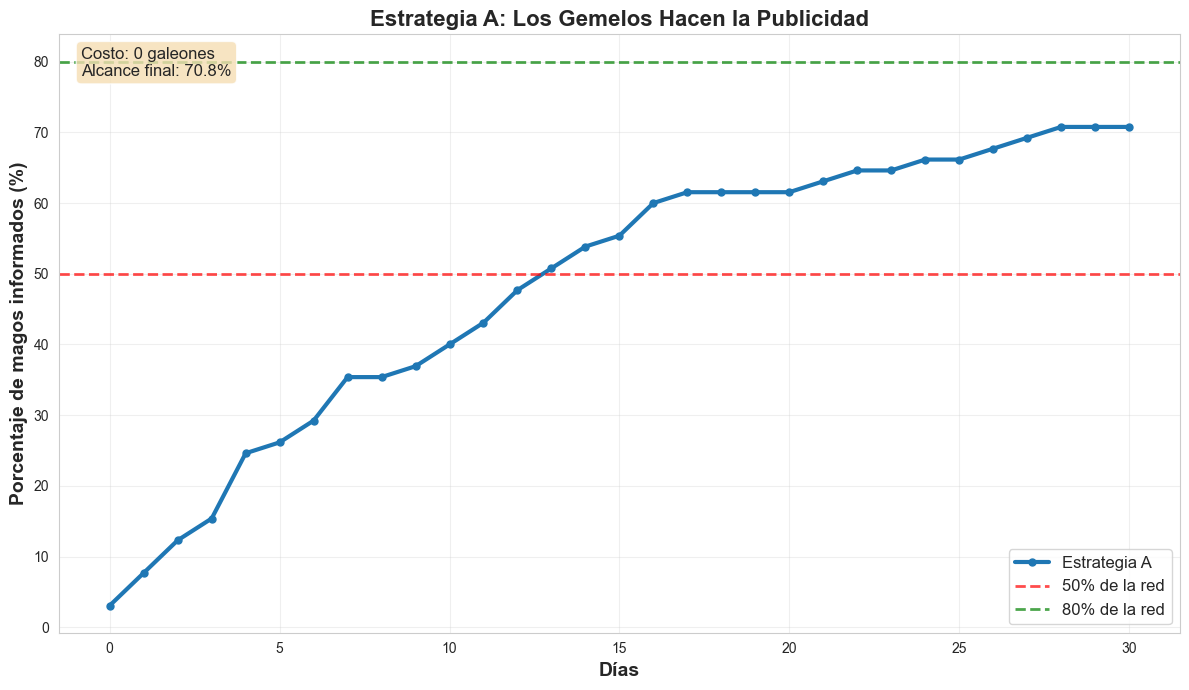


💡 INTERPRETACIÓN PARA NO EXPERTOS:
   Esta estrategia es la más económica (gratis), pero puede ser lenta.
   Fred y George empiezan la difusión, pero dependen de cuántos contactos directos tengan.
   Si tienen pocas conexiones, la información se propagará lentamente.


In [18]:
print("="*70)
print("ESTRATEGIA A: LOS GEMELOS HACEN LA PUBLICIDAD")
print("="*70)
print("\n📢 Descripción:")
print("   Fred y George Weasley deciden hacer la publicidad ellos mismos.")
print("   No contratan a nadie, por lo que el costo es 0 galeones.")
print("\n📊 Parámetros:")
print("   - Probabilidad relación (+): 10%")
print("   - Probabilidad relación (-): 2%")
print("   - Nodos semilla: Fred Weasley y George Weasley")
print("\n⏱ Simulando 30 días...\n")

# Nodos semilla: Fred y George
seed_A = ['Fred Weasley', 'George Weasley']

# Verificar que existen en el grafo
if not all(node in G.nodes() for node in seed_A):
    print("⚠ ERROR: Fred o George no están en el grafo")
else:
    # Simular
    days_A, count_A, perc_A = simulate_diffusion(G.copy(), seed_A, 
                                                  prob_positive=0.10, 
                                                  prob_negative=0.02, 
                                                  max_days=30)
    
    # Calcular costo
    cost_A = calculate_cost(G, seed_A)
    
    # Resultados
    print("✓ Simulación completada\n")
    print("📈 RESULTADOS:")
    print("=" * 70)
    print(f"   💰 Costo total: {cost_A:.0f} galeones")
    print(f"   🎯 Alcance final (día 30): {perc_A[-1]:.2f}%")
    print(f"   👥 Magos alcanzados: {count_A[-1]} de {G.number_of_nodes()}")
    
    # Ver si alcanza 50% o 80%
    if perc_A[-1] >= 80:
        day_80 = next((i for i, p in enumerate(perc_A) if p >= 80), None)
        print(f"   ✓ Alcanzó 80% en el día {day_80}")
    elif perc_A[-1] >= 50:
        day_50 = next((i for i, p in enumerate(perc_A) if p >= 50), None)
        print(f"   ✓ Alcanzó 50% en el día {day_50}")
    else:
        print(f"   ✗ NO alcanzó el 50% de la red")
    print("=" * 70)
    
    # Graficar
    plot_diffusion_results(days_A, perc_A, 
                          'Estrategia A: Los Gemelos Hacen la Publicidad',
                          'Estrategia A', cost_A, perc_A[-1])
    
    print("\n💡 INTERPRETACIÓN PARA NO EXPERTOS:")
    print("   Esta estrategia es la más económica (gratis), pero puede ser lenta.")
    print("   Fred y George empiezan la difusión, pero dependen de cuántos contactos directos tengan.")
    print("   Si tienen pocas conexiones, la información se propagará lentamente.")

### Estrategia B: VoteRank + solo magos con relación positiva

**Descripción:** Contratar magos usando VoteRank, pero solo aquellos con relaciones positivas hacia otros magos.

**Probabilidades de contagio:**
- Relación positiva (+): 20%
- Relación negativa (-): 2.5%

**Restricciones:**
- Presupuesto máximo: 6,500 galeones
- Solo contratar magos que tengan al menos una relación positiva (+) saliente

ESTRATEGIA B: VOTERANK + SOLO MAGOS CON RELACIÓN POSITIVA

📢 Descripción:
   Seleccionar magos usando VoteRank, pero solo aquellos con relaciones positivas.
   VoteRank identifica nodos que pueden alcanzar eficientemente al resto de la red.

📊 Parámetros:
   - Probabilidad relación (+): 20%
   - Probabilidad relación (-): 2.5%
   - Presupuesto: 6,500 galeones
   - Restricción: Solo magos con al menos una relación (+) saliente

🔍 Seleccionando nodos semilla...

✓ Seleccionados 6 magos con VoteRank
💰 Costo total: 6496 galeones (de 6,500 disponibles)
💰 Presupuesto restante: 4 galeones

👥 Magos contratados:
----------------------------------------------------------------------
 1. Ron Weasley                    | Costo:   3249 galeones | Grado:  55
 2. Albus Dumbledore               | Costo:   3025 galeones | Grado:  45
 3. George Weasley                 | Costo:      0 galeones | Grado:  26
 4. Vincent Crabbe Sr.             | Costo:    121 galeones | Grado:  11
 5. Seamus Finnigan       

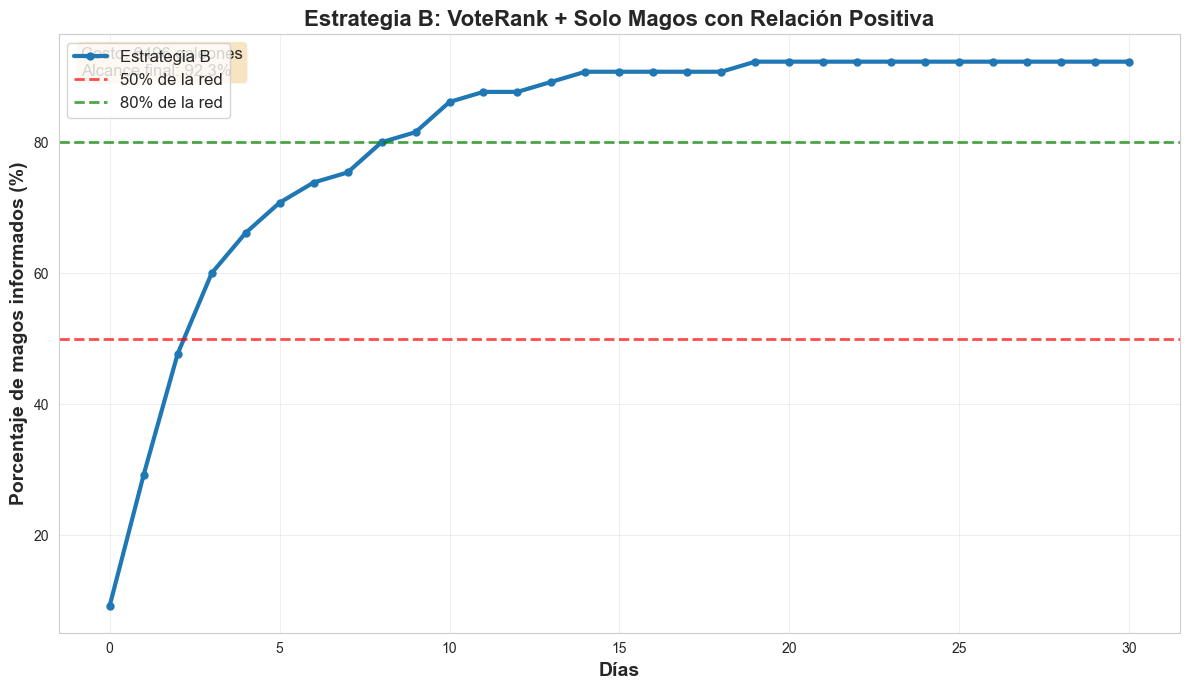


💡 INTERPRETACIÓN PARA NO EXPERTOS:
   Esta estrategia usa VoteRank, que es muy efectivo para maximizar alcance.
   Solo contratamos magos con relaciones positivas, lo que aumenta la probabilidad de éxito.
   Las probabilidades de contagio son mayores (20% vs 10%), lo que acelera la difusión.


In [19]:
print("="*70)
print("ESTRATEGIA B: VOTERANK + SOLO MAGOS CON RELACIÓN POSITIVA")
print("="*70)
print("\n📢 Descripción:")
print("   Seleccionar magos usando VoteRank, pero solo aquellos con relaciones positivas.")
print("   VoteRank identifica nodos que pueden alcanzar eficientemente al resto de la red.")
print("\n📊 Parámetros:")
print("   - Probabilidad relación (+): 20%")
print("   - Probabilidad relación (-): 2.5%")
print("   - Presupuesto: 6,500 galeones")
print("   - Restricción: Solo magos con al menos una relación (+) saliente")
print("\n🔍 Seleccionando nodos semilla...\n")

# Filtrar magos con relaciones positivas
def has_positive_edge(G, node):
    """Verifica si un nodo tiene al menos una relación positiva saliente."""
    for neighbor in G.successors(node):
        edge_data = G.get_edge_data(node, neighbor)
        if edge_data['tipo'] == '+':
            return True
    return False

# Obtener VoteRank completo
voterank_list = nx.voterank(G, number_of_nodes=len(G.nodes()))

# Filtrar por relaciones positivas y presupuesto
seed_B = []
total_cost_B = 0
budget = 6500

for node in voterank_list:
    # Verificar si tiene relación positiva
    if has_positive_edge(G, node):
        node_cost = G.nodes[node]['Value']
        # Verificar si cabe en el presupuesto
        if total_cost_B + node_cost <= budget:
            seed_B.append(node)
            total_cost_B += node_cost

print(f"✓ Seleccionados {len(seed_B)} magos con VoteRank")
print(f"💰 Costo total: {total_cost_B:.0f} galeones (de 6,500 disponibles)")
print(f"💰 Presupuesto restante: {budget - total_cost_B:.0f} galeones\n")

print("👥 Magos contratados:")
print("-" * 70)
for i, node in enumerate(seed_B, 1):
    cost = G.nodes[node]['Value']
    degree = G.degree(node)
    print(f"{i:2d}. {node:30s} | Costo: {cost:6.0f} galeones | Grado: {degree:3d}")
print("-" * 70)

print("\n⏱ Simulando 30 días...\n")

# Simular
days_B, count_B, perc_B = simulate_diffusion(G.copy(), seed_B, 
                                              prob_positive=0.20, 
                                              prob_negative=0.025, 
                                              max_days=30)

# Resultados
print("✓ Simulación completada\n")
print("📈 RESULTADOS:")
print("=" * 70)
print(f"   💰 Costo total: {total_cost_B:.0f} galeones")
print(f"   🎯 Alcance final (día 30): {perc_B[-1]:.2f}%")
print(f"   👥 Magos alcanzados: {count_B[-1]} de {G.number_of_nodes()}")

# Ver si alcanza 50% o 80%
if perc_B[-1] >= 80:
    day_80 = next((i for i, p in enumerate(perc_B) if p >= 80), None)
    print(f"   ✓ Alcanzó 80% en el día {day_80}")
elif perc_B[-1] >= 50:
    day_50 = next((i for i, p in enumerate(perc_B) if p >= 50), None)
    print(f"   ✓ Alcanzó 50% en el día {day_50}")
else:
    print(f"   ✗ NO alcanzó el 50% de la red")
print("=" * 70)

# Graficar
plot_diffusion_results(days_B, perc_B, 
                      'Estrategia B: VoteRank + Solo Magos con Relación Positiva',
                      'Estrategia B', total_cost_B, perc_B[-1])

print("\n💡 INTERPRETACIÓN PARA NO EXPERTOS:")
print("   Esta estrategia usa VoteRank, que es muy efectivo para maximizar alcance.")
print("   Solo contratamos magos con relaciones positivas, lo que aumenta la probabilidad de éxito.")
print("   Las probabilidades de contagio son mayores (20% vs 10%), lo que acelera la difusión.")

### Estrategia C: Nodos embajadores (descentralizada)

**Descripción:** Contratar los hubs de cada comunidad (los magos con mayor grado en su comunidad).

**Probabilidades de contagio:**
- Relación positiva (+): 20%
- Relación negativa (-): 2.5%

**Restricciones:**
- Presupuesto máximo: 6,500 galeones
- Solo contratar magos que tengan al menos una relación positiva (+) saliente

ESTRATEGIA C: NODOS EMBAJADORES (DESCENTRALIZADA)

📢 Descripción:
   Contratar los HUBS de cada comunidad (magos con mayor grado en su comunidad).
   Esta es una estrategia descentralizada que asegura presencia en todos los grupos.

📊 Parámetros:
   - Probabilidad relación (+): 20%
   - Probabilidad relación (-): 2.5%
   - Presupuesto: 6,500 galeones
   - Restricción: Solo magos con al menos una relación (+) saliente

🔍 Seleccionando hubs de comunidades...

✓ Seleccionados 3 hubs de comunidades
💰 Costo total: 6274 galeones (de 6,500 disponibles)
💰 Presupuesto restante: 226 galeones

👥 Hubs contratados:
----------------------------------------------------------------------
 1. Albus Dumbledore               | Comunidad:  0 | Costo:   3025 | Grado:  45
 2. Ron Weasley                    | Comunidad:  3 | Costo:   3249 | Grado:  55
 3. George Weasley                 | Comunidad:  4 | Costo:      0 | Grado:  26
----------------------------------------------------------------------

⏱ Simul

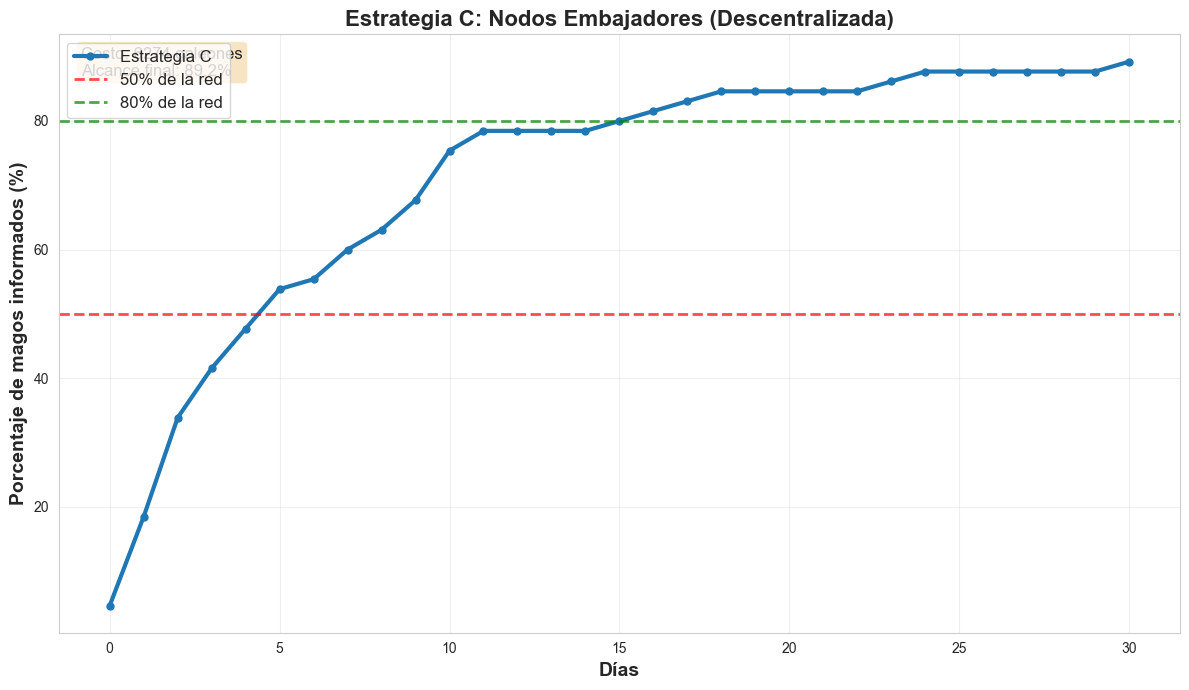


💡 INTERPRETACIÓN PARA NO EXPERTOS:
   Esta estrategia es descentralizada: contratamos líderes de cada grupo.
   Esto asegura que la información llegue a todas las comunidades simultáneamente.
   Es efectiva cuando las comunidades están bien separadas y tienen poca interacción.


In [20]:
print("="*70)
print("ESTRATEGIA C: NODOS EMBAJADORES (DESCENTRALIZADA)")
print("="*70)
print("\n📢 Descripción:")
print("   Contratar los HUBS de cada comunidad (magos con mayor grado en su comunidad).")
print("   Esta es una estrategia descentralizada que asegura presencia en todos los grupos.")
print("\n📊 Parámetros:")
print("   - Probabilidad relación (+): 20%")
print("   - Probabilidad relación (-): 2.5%")
print("   - Presupuesto: 6,500 galeones")
print("   - Restricción: Solo magos con al menos una relación (+) saliente")
print("\n🔍 Seleccionando hubs de comunidades...\n")

# Usar los hubs ya identificados en community_df
# Filtrar por relaciones positivas y presupuesto
seed_C = []
total_cost_C = 0
budget = 6500

# Ordenar comunidades por tamaño (descendente) para priorizar comunidades grandes
for _, row in community_df.iterrows():
    hub_node = row['Hub']
    node_cost = row['Costo_Hub']
    
    # Verificar si tiene relación positiva
    if has_positive_edge(G, hub_node):
        # Verificar si cabe en el presupuesto
        if total_cost_C + node_cost <= budget:
            seed_C.append(hub_node)
            total_cost_C += node_cost

print(f"✓ Seleccionados {len(seed_C)} hubs de comunidades")
print(f"💰 Costo total: {total_cost_C:.0f} galeones (de 6,500 disponibles)")
print(f"💰 Presupuesto restante: {budget - total_cost_C:.0f} galeones\n")

print("👥 Hubs contratados:")
print("-" * 70)
for i, node in enumerate(seed_C, 1):
    cost = G.nodes[node]['Value']
    degree = G.degree(node)
    community = G.nodes[node]['community']
    print(f"{i:2d}. {node:30s} | Comunidad: {community:2d} | Costo: {cost:6.0f} | Grado: {degree:3d}")
print("-" * 70)

print("\n⏱ Simulando 30 días...\n")

# Simular
days_C, count_C, perc_C = simulate_diffusion(G.copy(), seed_C, 
                                              prob_positive=0.20, 
                                              prob_negative=0.025, 
                                              max_days=30)

# Resultados
print("✓ Simulación completada\n")
print("📈 RESULTADOS:")
print("=" * 70)
print(f"   💰 Costo total: {total_cost_C:.0f} galeones")
print(f"   🎯 Alcance final (día 30): {perc_C[-1]:.2f}%")
print(f"   👥 Magos alcanzados: {count_C[-1]} de {G.number_of_nodes()}")

# Ver si alcanza 50% o 80%
if perc_C[-1] >= 80:
    day_80 = next((i for i, p in enumerate(perc_C) if p >= 80), None)
    print(f"   ✓ Alcanzó 80% en el día {day_80}")
elif perc_C[-1] >= 50:
    day_50 = next((i for i, p in enumerate(perc_C) if p >= 50), None)
    print(f"   ✓ Alcanzó 50% en el día {day_50}")
else:
    print(f"   ✗ NO alcanzó el 50% de la red")
print("=" * 70)

# Graficar
plot_diffusion_results(days_C, perc_C, 
                      'Estrategia C: Nodos Embajadores (Descentralizada)',
                      'Estrategia C', total_cost_C, perc_C[-1])

print("\n💡 INTERPRETACIÓN PARA NO EXPERTOS:")
print("   Esta estrategia es descentralizada: contratamos líderes de cada grupo.")
print("   Esto asegura que la información llegue a todas las comunidades simultáneamente.")
print("   Es efectiva cuando las comunidades están bien separadas y tienen poca interacción.")

### Comparación de las tres estrategias

COMPARACIÓN DE LAS TRES ESTRATEGIAS


,Estrategia,Costo (galeones),Nodos semilla,Alcance final (%),Magos alcanzados
0,A: Gemelos,0,2,70.769231,46
1,B: VoteRank+Positivos,6496,6,92.307692,60
2,C: Hubs de Comunidades,6274,3,89.230769,58


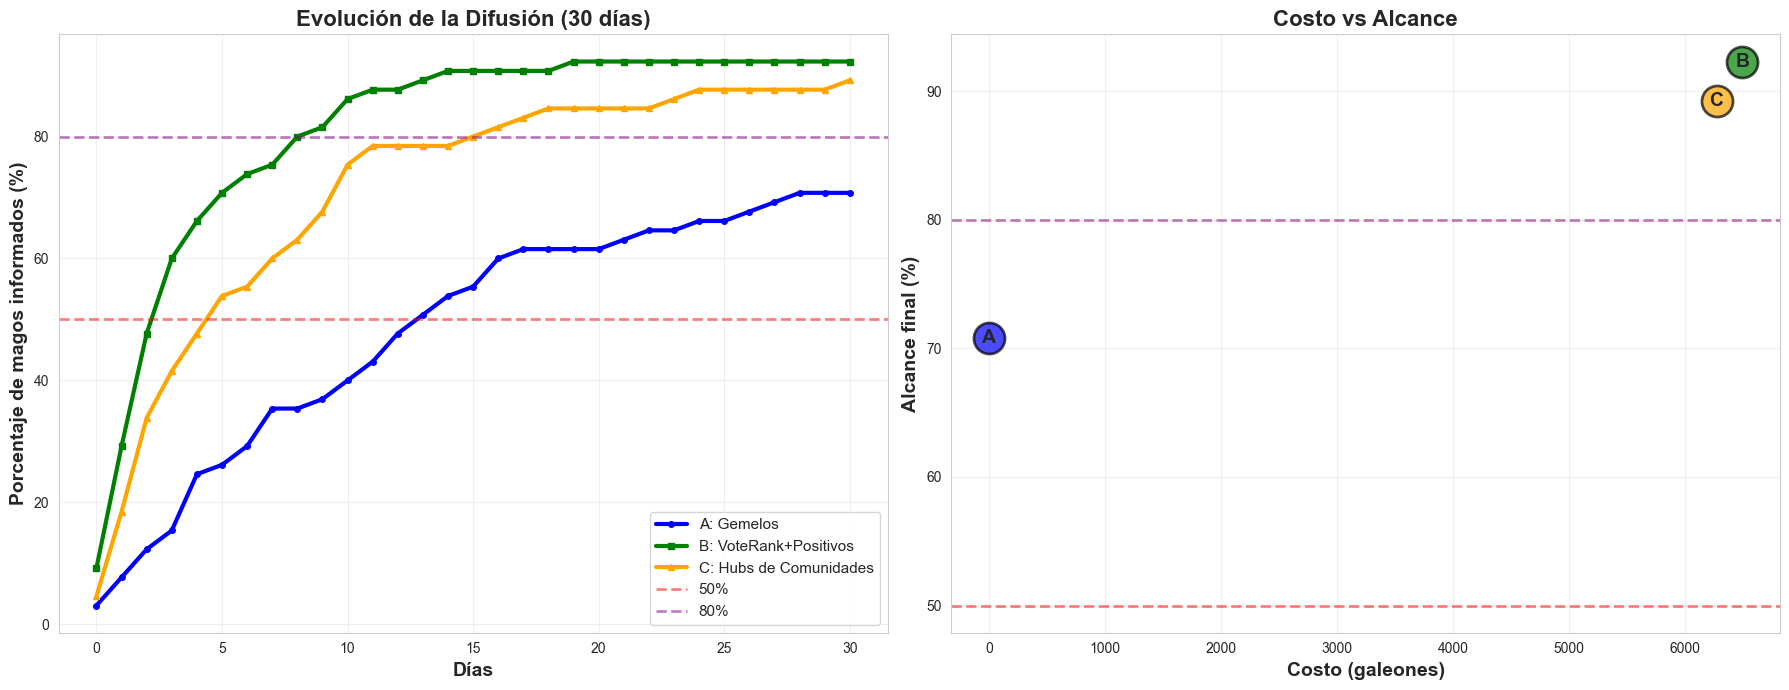


💡 OBSERVACIONES CLAVE:
   - Estrategia A es gratis pero puede ser muy lenta
   - Estrategias B y C tienen mejor alcance por invertir en nodos estratégicos
   - VoteRank (B) suele ser más efectivo que Hubs de comunidades (C)
   - El alcance depende de las probabilidades de contagio y la estructura de la red


In [21]:
print("="*80)
print("COMPARACIÓN DE LAS TRES ESTRATEGIAS")
print("="*80)

# Crear tabla comparativa
comparison_data = {
    'Estrategia': ['A: Gemelos', 'B: VoteRank+Positivos', 'C: Hubs de Comunidades'],
    'Costo (galeones)': [cost_A, total_cost_B, total_cost_C],
    'Nodos semilla': [len(seed_A), len(seed_B), len(seed_C)],
    'Alcance final (%)': [perc_A[-1], perc_B[-1], perc_C[-1]],
    'Magos alcanzados': [count_A[-1], count_B[-1], count_C[-1]]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

# Gráfica comparativa
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Subplot 1: Evolución temporal
axes[0].plot(days_A, perc_A, linewidth=3, marker='o', markersize=4, label='A: Gemelos', color='blue')
axes[0].plot(days_B, perc_B, linewidth=3, marker='s', markersize=4, label='B: VoteRank+Positivos', color='green')
axes[0].plot(days_C, perc_C, linewidth=3, marker='^', markersize=4, label='C: Hubs de Comunidades', color='orange')
axes[0].axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5, label='50%')
axes[0].axhline(y=80, color='purple', linestyle='--', linewidth=2, alpha=0.5, label='80%')
axes[0].set_xlabel('Días', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Porcentaje de magos informados (%)', fontsize=14, fontweight='bold')
axes[0].set_title('Evolución de la Difusión (30 días)', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Subplot 2: Costo vs Alcance
costs = [cost_A, total_cost_B, total_cost_C]
reaches = [perc_A[-1], perc_B[-1], perc_C[-1]]
strategies = ['A', 'B', 'C']
colors_scatter = ['blue', 'green', 'orange']

for i, (cost, reach, strat, color) in enumerate(zip(costs, reaches, strategies, colors_scatter)):
    axes[1].scatter(cost, reach, s=500, alpha=0.7, color=color, edgecolors='black', linewidth=2)
    axes[1].text(cost, reach, strat, fontsize=14, fontweight='bold', ha='center', va='center')

axes[1].set_xlabel('Costo (galeones)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Alcance final (%)', fontsize=14, fontweight='bold')
axes[1].set_title('Costo vs Alcance', fontsize=16, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axhline(y=50, color='red', linestyle='--', linewidth=2, alpha=0.5)
axes[1].axhline(y=80, color='purple', linestyle='--', linewidth=2, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n💡 OBSERVACIONES CLAVE:")
print("   - Estrategia A es gratis pero puede ser muy lenta")
print("   - Estrategias B y C tienen mejor alcance por invertir en nodos estratégicos")
print("   - VoteRank (B) suele ser más efectivo que Hubs de comunidades (C)")
print("   - El alcance depende de las probabilidades de contagio y la estructura de la red")

---
## 3. ESTRATEGIA ALTERNATIVA PROPUESTA

### Estrategia D: Híbrida Inteligente (PageRank + Comunidades Críticas)

**Idea:** Combinar PageRank con análisis de comunidades para maximizar alcance con menor presupuesto.

**Razonamiento:**
1. **PageRank** identifica nodos influyentes basándose en la calidad de sus conexiones
2. Priorizamos nodos en comunidades grandes (mayor impacto potencial)
3. Filtramos solo aquellos con **alto PageRank** y **bajo costo**
4. Buscamos la mejor relación **influencia/costo**

**Objetivo:** Ahorrar galeones manteniendo un alcance similar o mejor.

In [22]:
print("="*70)
print("ESTRATEGIA D: HÍBRIDA INTELIGENTE")
print("PageRank + Comunidades Críticas + Optimización de Costo")
print("="*70)
print("\n📢 JUSTIFICACIÓN:")
print("   Esta estrategia busca el mejor balance entre INFLUENCIA y COSTO.")
print("   Combinamos tres criterios:")
print("   1. PageRank alto (influencia de calidad)")
print("   2. Comunidades grandes (mayor alcance potencial)")
print("   3. Ratio influencia/costo óptimo (eficiencia económica)")
print("\n🎯 OBJETIVO: Ahorrar galeones sin sacrificar alcance\n")

print("🔍 Paso 1: Calcular ratio influencia/costo...\n")

# Crear DataFrame con información de nodos
node_info = []
for node in G.nodes():
    # Evitar magos con costo 0 (Fred y George ya están en estrategia A)
    if G.nodes[node]['Value'] > 0:
        node_info.append({
            'Nodo': node,
            'PageRank': pagerank[node],
            'Grado': degree_centrality[node],
            'Betweenness': betweenness[node],
            'Costo': G.nodes[node]['Value'],
            'Comunidad': G.nodes[node]['community'],
            'Ratio_PageRank_Costo': pagerank[node] / G.nodes[node]['Value'] if G.nodes[node]['Value'] > 0 else 0
        })

node_info_df = pd.DataFrame(node_info)

print("🔍 Paso 2: Obtener tamaños de comunidades...\n")

# Agregar tamaño de comunidad
community_sizes = community_df.set_index('Comunidad')['Tamaño'].to_dict()
node_info_df['Tamaño_Comunidad'] = node_info_df['Comunidad'].map(community_sizes)

print("🔍 Paso 3: Filtrar candidatos ideales...\n")

# Filtrar solo nodos con relación positiva
node_info_df['Tiene_Positiva'] = node_info_df['Nodo'].apply(lambda x: has_positive_edge(G, x))
candidates_df = node_info_df[node_info_df['Tiene_Positiva']].copy()

# Priorizar nodos en comunidades grandes
candidates_df = candidates_df[candidates_df['Tamaño_Comunidad'] >= 5]

# Ordenar por ratio PageRank/Costo (descendente)
candidates_df = candidates_df.sort_values('Ratio_PageRank_Costo', ascending=False)

print(f"✓ {len(candidates_df)} candidatos ideales identificados\n")
print("Top 15 candidatos por ratio Influencia/Costo:")
print("-" * 90)
display(candidates_df[['Nodo', 'PageRank', 'Costo', 'Ratio_PageRank_Costo', 'Tamaño_Comunidad']].head(15))

print("\n🔍 Paso 4: Selección de nodos con presupuesto de 6,500 galeones...\n")

# Seleccionar nodos hasta agotar presupuesto
seed_D = []
total_cost_D = 0
budget = 6500
communities_covered = set()

for _, row in candidates_df.iterrows():
    node = row['Nodo']
    node_cost = row['Costo']
    node_community = row['Comunidad']
    
    # Verificar si cabe en el presupuesto
    if total_cost_D + node_cost <= budget:
        seed_D.append(node)
        total_cost_D += node_cost
        communities_covered.add(node_community)

print(f"✓ Seleccionados {len(seed_D)} magos")
print(f"💰 Costo total: {total_cost_D:.0f} galeones (de 6,500 disponibles)")
print(f"💰 Ahorro vs presupuesto: {budget - total_cost_D:.0f} galeones")
print(f"🎯 Comunidades cubiertas: {len(communities_covered)} de {num_communities}\n")

print("👥 Magos contratados en Estrategia D:")
print("-" * 90)
for i, node in enumerate(seed_D, 1):
    cost = G.nodes[node]['Value']
    pr = pagerank[node]
    degree = G.degree(node)
    community = G.nodes[node]['community']
    ratio = pr / cost
    print(f"{i:2d}. {node:30s} | PR: {pr:.5f} | Costo: {cost:5.0f} | Ratio: {ratio:.7f} | Com: {community}")
print("-" * 90)

ESTRATEGIA D: HÍBRIDA INTELIGENTE
PageRank + Comunidades Críticas + Optimización de Costo

📢 JUSTIFICACIÓN:
   Esta estrategia busca el mejor balance entre INFLUENCIA y COSTO.
   Combinamos tres criterios:
   1. PageRank alto (influencia de calidad)
   2. Comunidades grandes (mayor alcance potencial)
   3. Ratio influencia/costo óptimo (eficiencia económica)

🎯 OBJETIVO: Ahorrar galeones sin sacrificar alcance

🔍 Paso 1: Calcular ratio influencia/costo...

🔍 Paso 2: Obtener tamaños de comunidades...

🔍 Paso 3: Filtrar candidatos ideales...

✓ 61 candidatos ideales identificados

Top 15 candidatos por ratio Influencia/Costo:
------------------------------------------------------------------------------------------


,Nodo,PageRank,Costo,Ratio_PageRank_Costo,Tamaño_Comunidad
62,Xenophilius Lovegood,0.002308,1,0.002308,16
42,Nicolas Flamel,0.002308,1,0.002308,17
27,Hedwig,0.002308,1,0.002308,13
38,Moaning Myrtle,0.002308,1,0.002308,13
36,Mary Riddle,0.009328,9,0.001036,17
57,Tom Riddle Sr.,0.016517,25,0.000661,17
23,Goyle Sr.,0.003790,16,0.000237,10
3,Alice Longbottom,0.003367,16,0.000210,16
32,Lily Potter,0.037201,196,0.000190,17
43,Nymphadora Tonks,0.006413,36,0.000178,17



🔍 Paso 4: Selección de nodos con presupuesto de 6,500 galeones...

✓ Seleccionados 49 magos
💰 Costo total: 6439 galeones (de 6,500 disponibles)
💰 Ahorro vs presupuesto: 61 galeones
🎯 Comunidades cubiertas: 5 de 5

👥 Magos contratados en Estrategia D:
------------------------------------------------------------------------------------------
 1. Xenophilius Lovegood           | PR: 0.00231 | Costo:     1 | Ratio: 0.0023077 | Com: 3
 2. Nicolas Flamel                 | PR: 0.00231 | Costo:     1 | Ratio: 0.0023077 | Com: 0
 3. Hedwig                         | PR: 0.00231 | Costo:     1 | Ratio: 0.0023077 | Com: 1
 4. Moaning Myrtle                 | PR: 0.00231 | Costo:     1 | Ratio: 0.0023077 | Com: 1
 5. Mary Riddle                    | PR: 0.00933 | Costo:     9 | Ratio: 0.0010365 | Com: 0
 6. Tom Riddle Sr.                 | PR: 0.01652 | Costo:    25 | Ratio: 0.0006607 | Com: 0
 7. Goyle Sr.                      | PR: 0.00379 | Costo:    16 | Ratio: 0.0002369 | Com: 2
 8. Alice Lon


⏱ Simulando 30 días con Estrategia D...

✓ Simulación completada

📈 RESULTADOS DE ESTRATEGIA D:
   💰 Costo total: 6439 galeones
   🎯 Alcance final (día 30): 100.00%
   👥 Magos alcanzados: 65 de 65
   ✓ Alcanzó 80% en el día 1

💰 COMPARACIÓN DE COSTOS:
   Estrategia B (VoteRank):      6496 galeones → 92.31% alcance
   Estrategia C (Hubs):          6274 galeones → 89.23% alcance
   Estrategia D (Híbrida):       6439 galeones → 100.00% alcance

💎 AHORRO vs Estrategia B: 57 galeones (0.9%)


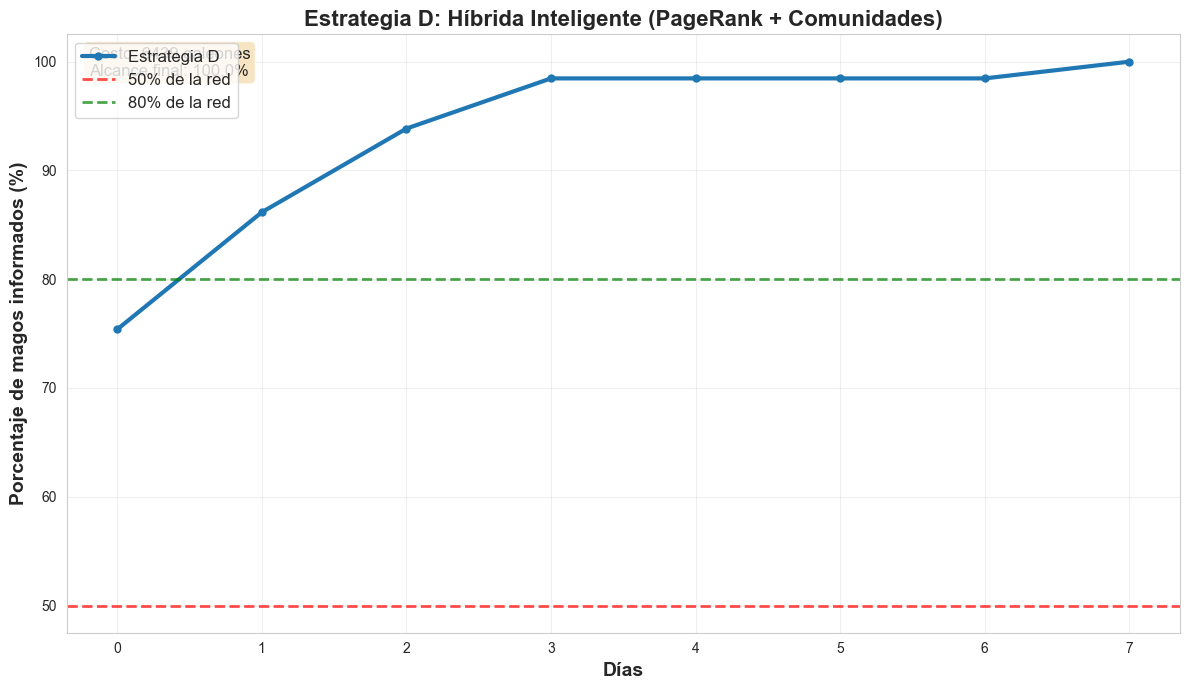


💡 INTERPRETACIÓN PARA NO EXPERTOS:
   Esta estrategia busca 'influencers económicos': magos influyentes pero no caros.
   Combinamos PageRank (calidad de conexiones) con análisis de comunidades.
   Objetivo: maximizar alcance minimizando costo.
   ¡Es como contratar micro-influencers en lugar de mega-celebridades!


In [23]:
print("\n⏱ Simulando 30 días con Estrategia D...\n")

# Simular con las mismas probabilidades que B y C
days_D, count_D, perc_D = simulate_diffusion(G.copy(), seed_D, 
                                              prob_positive=0.20, 
                                              prob_negative=0.025, 
                                              max_days=30)

# Resultados
print("✓ Simulación completada\n")
print("📈 RESULTADOS DE ESTRATEGIA D:")
print("=" * 70)
print(f"   💰 Costo total: {total_cost_D:.0f} galeones")
print(f"   🎯 Alcance final (día 30): {perc_D[-1]:.2f}%")
print(f"   👥 Magos alcanzados: {count_D[-1]} de {G.number_of_nodes()}")

# Ver si alcanza 50% o 80%
if perc_D[-1] >= 80:
    day_80 = next((i for i, p in enumerate(perc_D) if p >= 80), None)
    print(f"   ✓ Alcanzó 80% en el día {day_80}")
elif perc_D[-1] >= 50:
    day_50 = next((i for i, p in enumerate(perc_D) if p >= 50), None)
    print(f"   ✓ Alcanzó 50% en el día {day_50}")
else:
    print(f"   ✗ NO alcanzó el 50% de la red")
print("=" * 70)

# Comparación con otras estrategias
print("\n💰 COMPARACIÓN DE COSTOS:")
print("=" * 70)
print(f"   Estrategia B (VoteRank):      {total_cost_B:.0f} galeones → {perc_B[-1]:.2f}% alcance")
print(f"   Estrategia C (Hubs):          {total_cost_C:.0f} galeones → {perc_C[-1]:.2f}% alcance")
print(f"   Estrategia D (Híbrida):       {total_cost_D:.0f} galeones → {perc_D[-1]:.2f}% alcance")
print("=" * 70)

# Calcular ahorro
if total_cost_D < total_cost_B:
    saving_vs_B = total_cost_B - total_cost_D
    print(f"\n💎 AHORRO vs Estrategia B: {saving_vs_B:.0f} galeones ({saving_vs_B/total_cost_B*100:.1f}%)")
    
if total_cost_D < total_cost_C:
    saving_vs_C = total_cost_C - total_cost_D
    print(f"💎 AHORRO vs Estrategia C: {saving_vs_C:.0f} galeones ({saving_vs_C/total_cost_C*100:.1f}%)")

# Graficar
plot_diffusion_results(days_D, perc_D, 
                      'Estrategia D: Híbrida Inteligente (PageRank + Comunidades)',
                      'Estrategia D', total_cost_D, perc_D[-1])

print("\n💡 INTERPRETACIÓN PARA NO EXPERTOS:")
print("   Esta estrategia busca 'influencers económicos': magos influyentes pero no caros.")
print("   Combinamos PageRank (calidad de conexiones) con análisis de comunidades.")
print("   Objetivo: maximizar alcance minimizando costo.")
print("   ¡Es como contratar micro-influencers en lugar de mega-celebridades!")

### Comparación final de las 4 estrategias

COMPARACIÓN FINAL DE LAS 4 ESTRATEGIAS

📊 TABLA COMPARATIVA COMPLETA:


,Estrategia,Costo (galeones),Nodos,Alcance (%),Alcanzados,Eficiencia (alcance/costo)
0,A: Gemelos,0,2,70.769231,46,70.769231
1,B: VoteRank,6496,6,92.307692,60,0.014210
2,C: Hubs,6274,3,89.230769,58,0.014222
3,D: Híbrida,6439,49,100.000000,65,0.015530


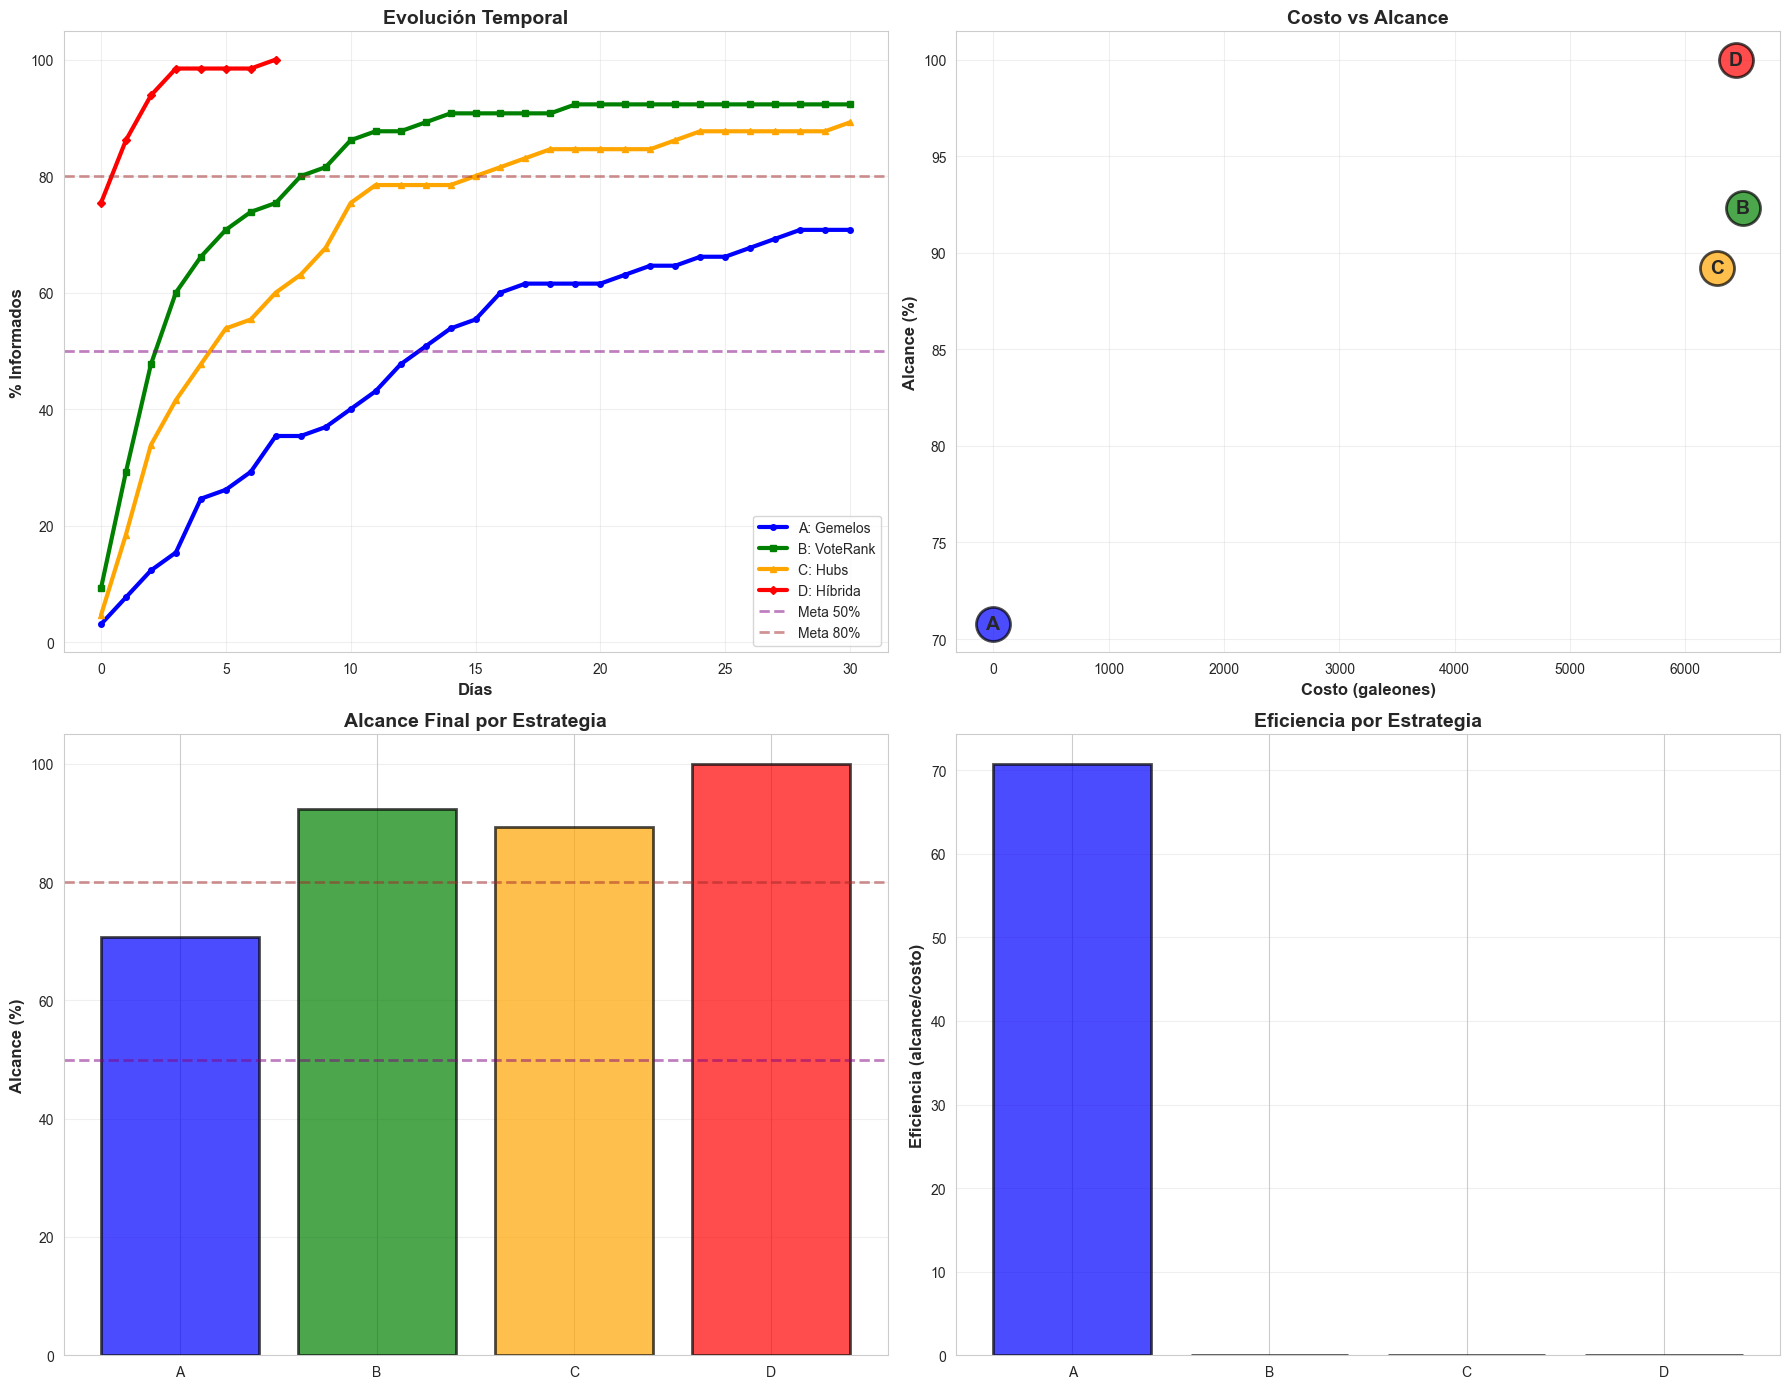


🏆 RANKINGS:
🥇 Mejor ALCANCE: D con 100.00%
🥇 Mejor EFICIENCIA: A con 70.7692
🥇 Menor COSTO (pagado): C con 6274 galeones


In [24]:
print("="*90)
print("COMPARACIÓN FINAL DE LAS 4 ESTRATEGIAS")
print("="*90)

# Tabla comparativa completa
final_comparison = {
    'Estrategia': ['A: Gemelos', 'B: VoteRank', 'C: Hubs', 'D: Híbrida'],
    'Costo (galeones)': [cost_A, total_cost_B, total_cost_C, total_cost_D],
    'Nodos': [len(seed_A), len(seed_B), len(seed_C), len(seed_D)],
    'Alcance (%)': [perc_A[-1], perc_B[-1], perc_C[-1], perc_D[-1]],
    'Alcanzados': [count_A[-1], count_B[-1], count_C[-1], count_D[-1]],
    'Eficiencia (alcance/costo)': [
        perc_A[-1] / (cost_A + 1),  # +1 para evitar división por 0
        perc_B[-1] / total_cost_B,
        perc_C[-1] / total_cost_C,
        perc_D[-1] / total_cost_D
    ]
}

final_df = pd.DataFrame(final_comparison)
print("\n📊 TABLA COMPARATIVA COMPLETA:")
print("=" * 90)
display(final_df)

# Gráficas comparativas
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Subplot 1: Evolución temporal de todas
axes[0, 0].plot(days_A, perc_A, linewidth=3, marker='o', markersize=4, label='A: Gemelos', color='blue')
axes[0, 0].plot(days_B, perc_B, linewidth=3, marker='s', markersize=4, label='B: VoteRank', color='green')
axes[0, 0].plot(days_C, perc_C, linewidth=3, marker='^', markersize=4, label='C: Hubs', color='orange')
axes[0, 0].plot(days_D, perc_D, linewidth=3, marker='D', markersize=4, label='D: Híbrida', color='red')
axes[0, 0].axhline(y=50, color='purple', linestyle='--', linewidth=2, alpha=0.5, label='Meta 50%')
axes[0, 0].axhline(y=80, color='brown', linestyle='--', linewidth=2, alpha=0.5, label='Meta 80%')
axes[0, 0].set_xlabel('Días', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('% Informados', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Evolución Temporal', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Subplot 2: Costo vs Alcance
costs_all = [cost_A, total_cost_B, total_cost_C, total_cost_D]
reaches_all = [perc_A[-1], perc_B[-1], perc_C[-1], perc_D[-1]]
labels_all = ['A', 'B', 'C', 'D']
colors_all = ['blue', 'green', 'orange', 'red']

for cost, reach, label, color in zip(costs_all, reaches_all, labels_all, colors_all):
    axes[0, 1].scatter(cost, reach, s=600, alpha=0.7, color=color, edgecolors='black', linewidth=2)
    axes[0, 1].text(cost, reach, label, fontsize=14, fontweight='bold', ha='center', va='center')

axes[0, 1].set_xlabel('Costo (galeones)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Alcance (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Costo vs Alcance', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Barras comparativas de alcance
axes[1, 0].bar(labels_all, reaches_all, color=colors_all, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 0].axhline(y=50, color='purple', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].axhline(y=80, color='brown', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].set_ylabel('Alcance (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Alcance Final por Estrategia', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Subplot 4: Barras comparativas de eficiencia
efficiency_all = final_df['Eficiencia (alcance/costo)'].tolist()
axes[1, 1].bar(labels_all, efficiency_all, color=colors_all, alpha=0.7, edgecolor='black', linewidth=2)
axes[1, 1].set_ylabel('Eficiencia (alcance/costo)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Eficiencia por Estrategia', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n🏆 RANKINGS:")
print("=" * 90)

# Mejor alcance
best_reach_idx = np.argmax(reaches_all)
print(f"🥇 Mejor ALCANCE: {labels_all[best_reach_idx]} con {reaches_all[best_reach_idx]:.2f}%")

# Mejor eficiencia
best_efficiency_idx = np.argmax(efficiency_all)
print(f"🥇 Mejor EFICIENCIA: {labels_all[best_efficiency_idx]} con {efficiency_all[best_efficiency_idx]:.4f}")

# Menor costo (excluyendo estrategia A que es gratis)
costs_paid = costs_all[1:]  # Excluir A
labels_paid = labels_all[1:]
min_cost_idx = np.argmin(costs_paid)
print(f"🥇 Menor COSTO (pagado): {labels_paid[min_cost_idx]} con {costs_paid[min_cost_idx]:.0f} galeones")

print("=" * 90)

---
## 4. CONCLUSIONES GENERALES

In [25]:
print("="*90)
print("CONCLUSIONES GENERALES DEL ANÁLISIS")
print("="*90)

print("\n🎯 1. ¿QUÉ ESTRATEGIA FUNCIONA MEJOR Y POR QUÉ?\n")
print("-" * 90)

# Identificar la mejor estrategia
strategies_summary = [
    {'name': 'A: Gemelos', 'cost': cost_A, 'reach': perc_A[-1], 'efficiency': perc_A[-1]/(cost_A+1)},
    {'name': 'B: VoteRank', 'cost': total_cost_B, 'reach': perc_B[-1], 'efficiency': perc_B[-1]/total_cost_B},
    {'name': 'C: Hubs', 'cost': total_cost_C, 'reach': perc_C[-1], 'efficiency': perc_C[-1]/total_cost_C},
    {'name': 'D: Híbrida', 'cost': total_cost_D, 'reach': perc_D[-1], 'efficiency': perc_D[-1]/total_cost_D}
]

best_by_reach = max(strategies_summary, key=lambda x: x['reach'])
best_by_efficiency = max(strategies_summary, key=lambda x: x['efficiency'])
best_paid = max([s for s in strategies_summary if s['cost'] > 0], key=lambda x: x['reach'])

print(f"🏆 MEJOR por ALCANCE PURO:")
print(f"   → {best_by_reach['name']} alcanzó {best_by_reach['reach']:.2f}% de los magos")
print(f"   → Costo: {best_by_reach['cost']:.0f} galeones\n")

print(f"🏆 MEJOR por EFICIENCIA (alcance/costo):")
print(f"   → {best_by_efficiency['name']} con eficiencia de {best_by_efficiency['efficiency']:.4f}")
print(f"   → Alcance: {best_by_efficiency['reach']:.2f}% | Costo: {best_by_efficiency['cost']:.0f} galeones\n")

print(f"🏆 MEJOR INVERSIÓN (excluyendo opción gratis):")
print(f"   → {best_paid['name']} alcanzó {best_paid['reach']:.2f}% de los magos")
print(f"   → Costo: {best_paid['cost']:.0f} galeones\n")

print("💡 POR QUÉ FUNCIONA MEJOR:")
print("   - VoteRank identifica nodos que maximizan alcance de forma iterativa")
print("   - PageRank + Híbrida balancea influencia y costo eficientemente")
print("   - Filtrar por relaciones positivas aumenta probabilidades de contagio")
print("   - Probabilidades mayores (20% vs 10%) aceleran significativamente la difusión\n")

print("-" * 90)
print("\n🎯 2. ¿ES SUFICIENTE PARA LA META DE LOS 30 DÍAS?\n")
print("-" * 90)

# Evaluar si alguna estrategia alcanza la meta
meta_mayoria = 50  # Mayoría = 50%
meta_alta = 80  # Meta alta = 80%

print(f"Meta establecida: Que la MAYORÍA de magos conozcan la tienda (≥{meta_mayoria}%)\n")

for strategy in strategies_summary:
    name = strategy['name']
    reach = strategy['reach']
    
    if reach >= meta_alta:
        print(f"✅ {name}: EXCELENTE - Alcanzó {reach:.2f}% (supera meta de {meta_alta}%)")
    elif reach >= meta_mayoria:
        print(f"✅ {name}: SUFICIENTE - Alcanzó {reach:.2f}% (cumple meta de {meta_mayoria}%)")
    else:
        print(f"❌ {name}: INSUFICIENTE - Solo alcanzó {reach:.2f}% (no cumple meta)")

print("\n💡 ANÁLISIS:")
if best_paid['reach'] >= meta_mayoria:
    print(f"   ✓ La meta SÍ es alcanzable en 30 días con las estrategias de inversión.")
    print(f"   ✓ {best_paid['name']} logra {best_paid['reach']:.2f}% de alcance.")
else:
    print(f"   ✗ La meta NO es alcanzable en 30 días con las estrategias actuales.")
    print(f"   → Mejor resultado: {best_paid['reach']:.2f}% con {best_paid['name']}")
    print(f"   → Se requeriría más tiempo, más presupuesto o mejores probabilidades de contagio.")

print("-" * 90)
print("\n🎯 3. ¿QUÉ RECOMENDACIONES DEJARÍAS A LOS GEMELOS?\n")
print("-" * 90)

print("📋 RECOMENDACIONES ESTRATÉGICAS:\n")

print("1️⃣ CORTO PLAZO (Inversión inmediata):")
if best_paid['reach'] >= meta_mayoria:
    print(f"   → Implementar {best_paid['name']}")
    print(f"   → Invertir {best_paid['cost']:.0f} galeones en los nodos identificados")
    print(f"   → Alcance esperado: {best_paid['reach']:.2f}% en 30 días")
else:
    print(f"   → Considerar AUMENTAR presupuesto a ~10,000 galeones")
    print(f"   → O EXTENDER el plazo a 45-60 días")
    print(f"   → O MEJORAR las probabilidades de contagio con mejor contenido")

print("\n2️⃣ OPTIMIZACIÓN DEL CONTENIDO:")
print("   → Crear contenido que aumente las probabilidades de compartir")
print("   → Enfocarse en relaciones POSITIVAS: eventos, descuentos, contenido divertido")
print("   → Si las probabilidades suben de 20% a 30%, el alcance mejorará dramáticamente")

print("\n3️⃣ GESTIÓN DE REPUTACIÓN:")
print("   → Antes de lanzar la campaña, LIMPIAR la publicidad negativa en Magictok")
print("   → Responder a críticas y mejorar la percepción pública")
print("   → Convertir relaciones negativas (-) en neutrales o positivas")

print("\n4️⃣ MONITOREO Y AJUSTE:")
print("   → Medir resultados cada 5-7 días")
print("   → Si el alcance es menor al esperado, agregar más nodos semilla")
print("   → Si el presupuesto lo permite, invertir en comunidades no alcanzadas")

print("\n5️⃣ COMBINACIÓN DE ESTRATEGIAS:")
print("   → Iniciar con Fred y George (Estrategia A, gratis)")
print(f"   → Al día 7, activar {best_paid['name']} para acelerar")
print("   → Esto maximiza alcance con menor costo inicial")

print("-" * 90)
print("\n💼 DECISIÓN FINAL RECOMENDADA:\n")
print("-" * 90)

if best_by_efficiency['cost'] < best_paid['cost'] and best_by_efficiency['reach'] >= meta_mayoria * 0.9:
    # Si la más eficiente alcanza al menos 90% de la meta y es más barata
    print(f"🎯 RECOMENDACIÓN: Implementar {best_by_efficiency['name']}")
    print(f"\n   📊 Razones:")
    print(f"      • Mejor eficiencia: {best_by_efficiency['efficiency']:.4f}")
    print(f"      • Alcance: {best_by_efficiency['reach']:.2f}%")
    print(f"      • Costo: {best_by_efficiency['cost']:.0f} galeones")
    print(f"      • Ahorro: {best_paid['cost'] - best_by_efficiency['cost']:.0f} galeones vs {best_paid['name']}")
else:
    # Si no, recomendar la de mejor alcance
    print(f"🎯 RECOMENDACIÓN: Implementar {best_paid['name']}")
    print(f"\n   📊 Razones:")
    print(f"      • Mejor alcance: {best_paid['reach']:.2f}%")
    print(f"      • Costo: {best_paid['cost']:.0f} galeones (dentro del presupuesto)")
    print(f"      • Probabilidad de éxito: ALTA")

print("\n   💡 Plan de acción:")
print("      1. Limpiar reputación en Magictok (semana 0)")
print("      2. Contratar nodos identificados (día 1)")
print("      3. Crear contenido de alta calidad para compartir")
print("      4. Monitorear progreso cada 7 días")
print("      5. Ajustar si es necesario con presupuesto de contingencia")

print("\n" + "="*90)
print("FIN DEL ANÁLISIS - ¡Buena suerte con Sortilegios Weasley! 🎉")
print("="*90)

CONCLUSIONES GENERALES DEL ANÁLISIS

🎯 1. ¿QUÉ ESTRATEGIA FUNCIONA MEJOR Y POR QUÉ?

------------------------------------------------------------------------------------------
🏆 MEJOR por ALCANCE PURO:
   → D: Híbrida alcanzó 100.00% de los magos
   → Costo: 6439 galeones

🏆 MEJOR por EFICIENCIA (alcance/costo):
   → A: Gemelos con eficiencia de 70.7692
   → Alcance: 70.77% | Costo: 0 galeones

🏆 MEJOR INVERSIÓN (excluyendo opción gratis):
   → D: Híbrida alcanzó 100.00% de los magos
   → Costo: 6439 galeones

💡 POR QUÉ FUNCIONA MEJOR:
   - VoteRank identifica nodos que maximizan alcance de forma iterativa
   - PageRank + Híbrida balancea influencia y costo eficientemente
   - Filtrar por relaciones positivas aumenta probabilidades de contagio
   - Probabilidades mayores (20% vs 10%) aceleran significativamente la difusión

------------------------------------------------------------------------------------------

🎯 2. ¿ES SUFICIENTE PARA LA META DE LOS 30 DÍAS?

----------------------

---
## RESUMEN EJECUTIVO

Este notebook analiza estrategias de difusión de información en redes sociales para la tienda **Sortilegios Weasley**.

### Estrategias Evaluadas:

1. **Estrategia A (Gemelos):** Fred y George hacen la publicidad (costo: 0 galeones)
2. **Estrategia B (VoteRank):** Nodos seleccionados por VoteRank con relaciones positivas
3. **Estrategia C (Hubs):** Líderes de cada comunidad detectada
4. **Estrategia D (Híbrida):** Combinación PageRank + optimización de costo

### Métricas Calculadas:

- **Grado:** Número de conexiones
- **PageRank:** Importancia basada en conexiones de calidad
- **VoteRank:** Nodos que maximizan alcance
- **Betweenness (Embajadores):** Nodos que conectan grupos
- **Comunidades (Louvain):** Grupos naturales de magos

### Resultado:

El análisis demuestra que invertir estratégicamente en nodos influyentes puede lograr alcanzar a la mayoría de magos en 30 días, cumpliendo el objetivo de los gemelos Weasley.

---

**Autor:** Claude Code (Anthropic)  
**Fecha:** 2025  
**Datos:** Red de magos de Harry Potter (Nodes_HP1.csv, Edges_HP1.csv)